https://www.kaggle.com/c/porto-seguro-data-challenge

###### Acessar https://drive.google.com/drive/folders/1jFo7K5X749N8LzF-SuDBD-zB1YGXJqjs?usp=sharing

Clicar em "Adicionar Atalho ao Google Drive"

In [1]:
path_notebook = '/content/drive/MyDrive/Desafio_Kaggle/'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
import os
import sys
sys.path.insert(0, os.path.dirname(path_notebook))

In [4]:
import AleTransforms as trf
import AleDatasetAnalysis as dat
import AleMLAnalysis as aml
import AleExplainers as exp
import AleLearners as lrn

In [5]:
import importlib
importlib.reload(trf)
importlib.reload(dat)
importlib.reload(aml)
importlib.reload(exp)
importlib.reload(lrn)

<module 'AleLearners' from '/content/drive/MyDrive/Desafio_Kaggle/AleLearners.py'>

# Acessando API do Kaggle, Download e Extração do Dataset

In [6]:
#Instala a API
!pip install kaggle

In [7]:
# Move minhas credenciais para a pasta em que a API foi instalada
!mkdir -p ~/.kaggle/ && cp -i /content/drive/MyDrive/Desafio_Kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [8]:
#Baixa dos dados do Projeto, descompacta e deleta arquivo zip
!kaggle competitions download -c porto-seguro-data-challenge

  0% 0.00/1.85k [00:00<?, ?B/s]
100% 1.85k/1.85k [00:00<00:00, 761kB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 22.4MB/s]
  0% 0.00/1.65M [00:00<?, ?B/s]
100% 1.65M/1.65M [00:00<00:00, 94.0MB/s]
  0% 0.00/2.46M [00:00<?, ?B/s]
100% 2.46M/2.46M [00:00<00:00, 80.7MB/s]


# Começa a fazer os Trem

In [9]:
!pip install Catboost

     |████████████████████████████████| 67.4 MB 55 kB/s 


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, KFold

from catboost import CatBoostClassifier 
import matplotlib.pyplot as plt
from functools import reduce

import joblib

In [11]:
!ls

drive	      sample_data	     test.csv.zip
metadata.csv  submission_sample.csv  train.csv.zip


In [12]:
pd.read_csv('metadata.csv')

,Variavel cod,Variavel tipo
0,id,Qualitativo nominal
1,var1,Qualitativo nominal
2,var2,Qualitativo nominal
3,var3,Qualitativo nominal
4,var4,Qualitativo nominal
...,...,...
65,var65,Quantitativo continua
66,var66,Quantitativo continua
67,var67,Quantitativo discreto
68,var68,Quantitativo discreto


In [13]:
df = pd.read_csv('train.csv.zip')

In [14]:
df

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
0,1,18,19,2853,29442,1386,2435,35,-999,3,63,6498,1166,2007,26,13,11,11,4,1547,26,2068,1,3,0,4,7,0,24,4,2,0,16,3,44,463,27,2,0,4,9,3,25,6,1,4,3,1,0,0,0,0,42,1,1,0.212414,0.137,0.833333,0.037822,0.058070,0.311441,0.142303,0.056146,0.632694,0.024054,0.253356,0.00603,0.132353,0.139706,1
1,8,4,110,1986,13684,7189,-999,-999,17,3,63,13989,497,2289,16,1,3,3,3,1797,16,2417,5,1,2,1,6,1,4,2,1,0,14,0,1,532,2,1,0,4,7,3,30,3,0,0,0,0,0,0,0,0,20,1,1,0.228784,0.308,0.305376,0.069325,0.248909,-999.000000,-999.000000,0.070991,0.773966,0.019315,-999.000000,-999.00000,0.147059,0.106618,0
2,30,0,39,1019,10232,678,791,16,-999,3,63,9739,562,641,10,34,34,10,4,511,10,664,5,3,2,1,7,0,3,4,1,0,11,1,3,81,26,3,0,4,3,3,23,5,1,0,0,0,0,0,0,0,12,1,1,0.204636,0.213,0.451613,0.018639,0.214520,-999.000000,0.200814,0.051046,0.980827,0.018536,-999.000000,-999.00000,0.382353,0.242647,0
3,43,20,39,1751,2689,8235,1042,13,10,1,14,2890,6541,811,8,59,60,23,5,624,8,839,0,0,0,0,1,1,19,1,2,0,8,0,11,414,27,0,0,4,10,3,22,10,1,1,1,0,1,1,0,0,36,1,1,0.208299,0.716,0.101075,0.204753,0.349421,-999.000000,0.352379,0.044301,0.951564,0.023684,0.363370,0.00201,0.147059,0.132353,0
4,46,7,44,2262,29428,6031,304,16,-999,3,63,13541,7238,260,10,55,56,20,5,1413,10,270,2,3,2,1,8,1,3,4,1,0,17,4,3,567,8,3,2,4,5,3,26,5,1,0,0,0,0,1,0,0,19,1,1,0.222896,0.596,0.101075,0.140394,0.189641,0.021226,0.226161,0.059125,0.906155,0.020733,-999.000000,-999.00000,0.455882,0.132353,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14118,35295,4,39,2511,28766,1109,2094,31,24,3,-999,5082,-999,1678,23,55,56,20,5,198,23,1739,5,4,2,1,7,0,26,5,1,0,17,5,12,314,0,1,0,4,2,3,23,5,1,0,0,0,0,0,0,0,25,2,2,0.227307,0.048,0.978495,0.063199,0.122448,-999.000000,0.069347,0.036178,0.869828,0.016160,-999.000000,-999.00000,0.455882,0.147059,0
14119,35296,19,129,1114,-999,6376,-999,-999,27,-999,-999,-999,-999,1387,13,-999,-999,-999,-999,719,13,1445,5,1,1,2,-999,0,24,4,1,0,13,6,25,532,27,1,0,4,10,1,26,13,1,0,0,0,0,0,1,0,-999,0,0,0.210104,-999.000,-999.000000,-999.000000,-999.000000,-999.000000,0.295418,0.055899,0.921292,0.018293,-999.000000,-999.00000,0.147059,0.198529,0
14120,35301,27,44,1786,23761,9048,623,35,27,3,14,1249,882,358,26,34,34,10,4,482,26,380,5,3,2,1,7,0,24,4,1,0,17,3,44,362,2,0,0,4,1,3,25,4,1,0,0,0,0,0,0,0,16,2,2,0.217944,0.029,1.000000,0.034263,0.207001,-999.000000,0.203394,0.040697,0.930373,0.009440,-999.000000,-999.00000,0.397059,0.158088,0
14121,35304,4,89,210,19593,3634,2453,35,27,1,63,21128,3849,2033,26,55,56,20,5,1573,26,2093,3,3,0,0,7,0,24,4,2,0,16,2,24,553,0,18,0,4,1,3,28,14,1,0,0,0,0,1,0,1,21,2,2,0.209336,0.154,0.833333,0.022503,0.200405,0.070788,0.381038,0.100384,0.680121,0.041096,-999.000000,-999.00000,0.264706,0.128676,0


In [15]:
df[df == -999] = np.nan

In [16]:
analiseexp = dat.DistribuicoesDataset(df, num_div = 10, num_cat = 5)

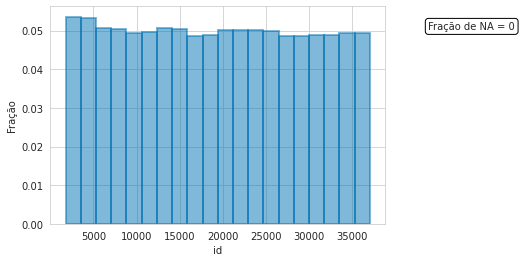

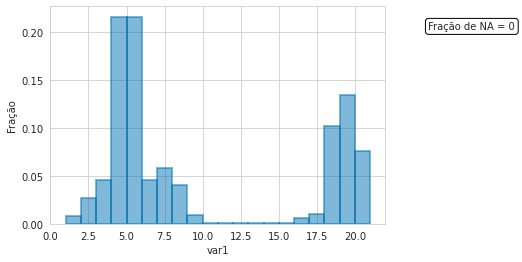

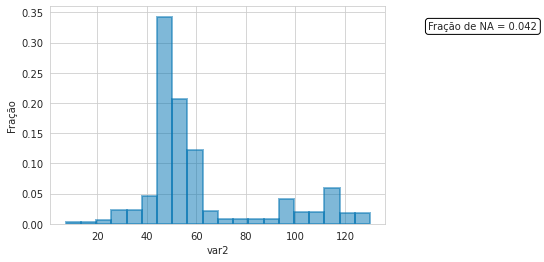

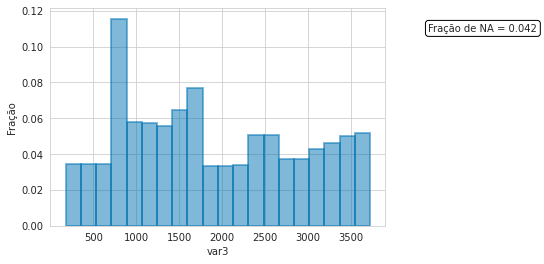

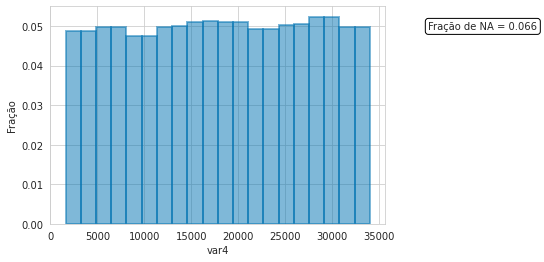

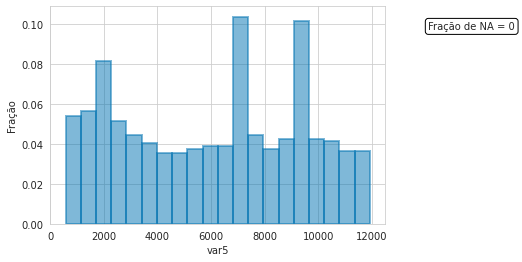

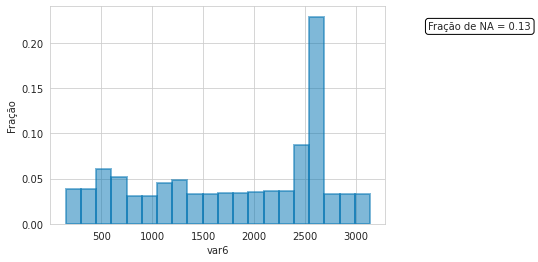

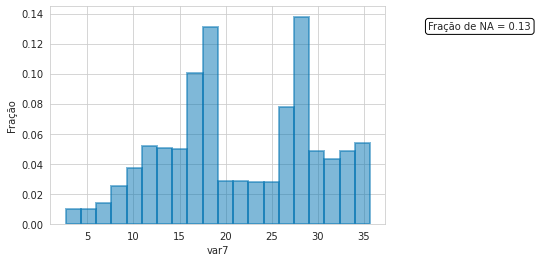

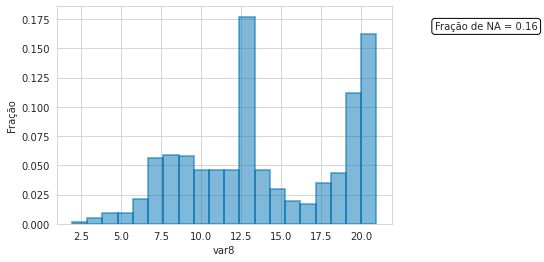

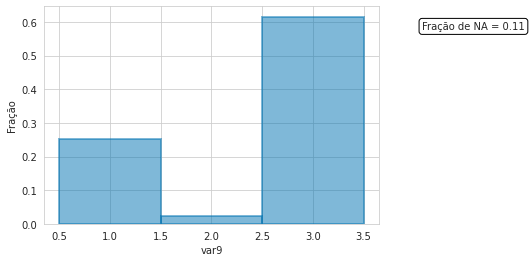

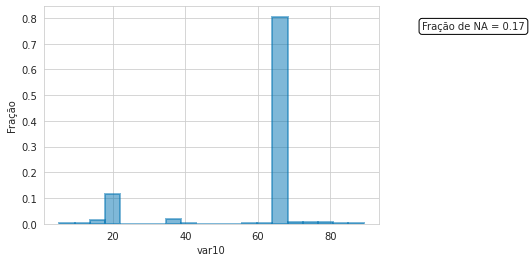

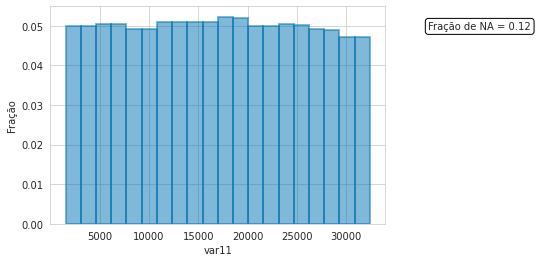

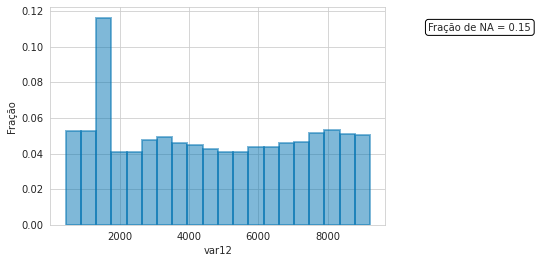

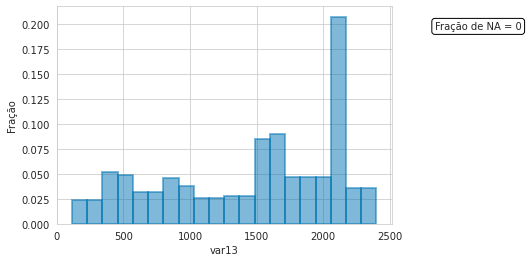

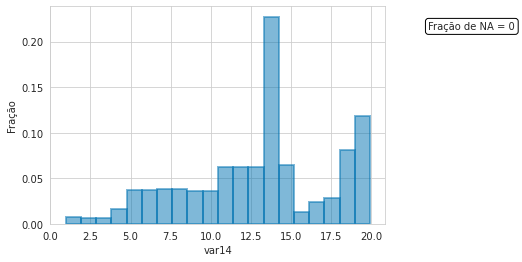

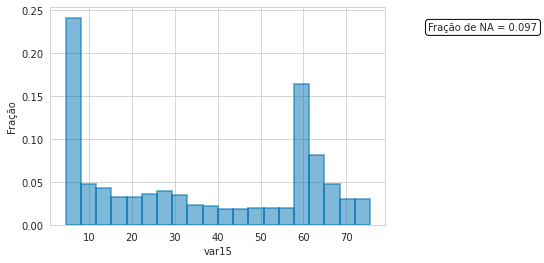

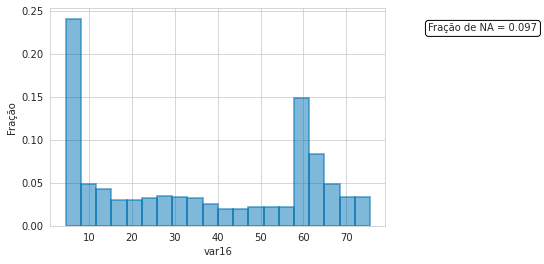

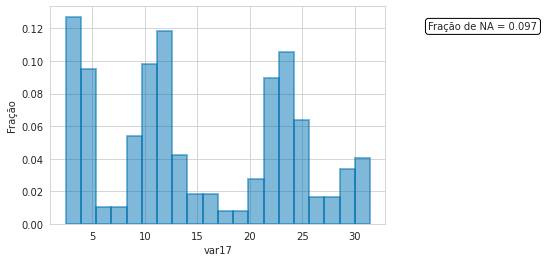

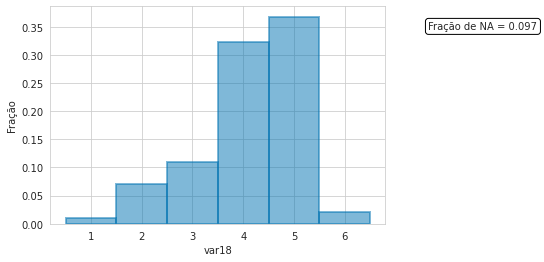

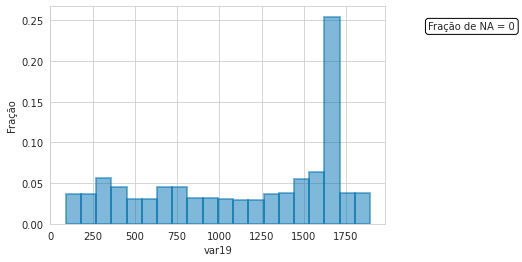

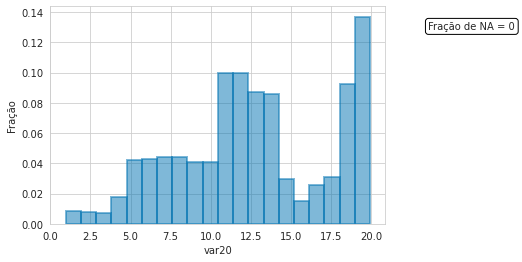

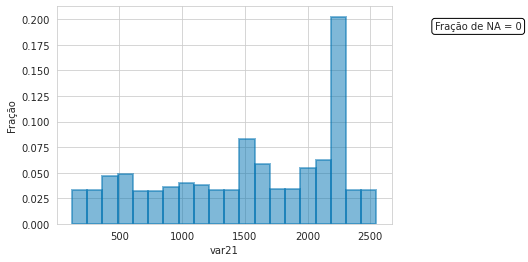

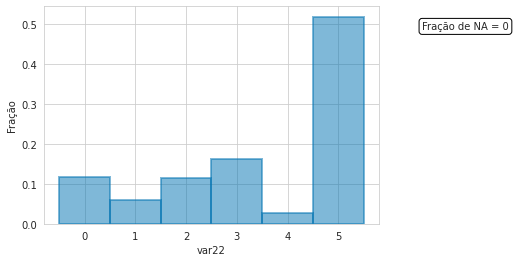

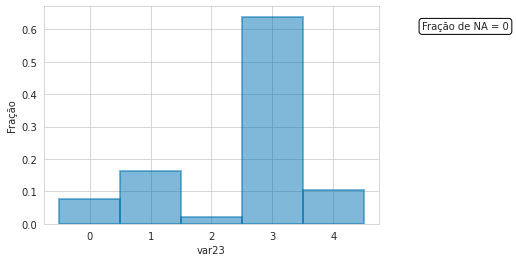

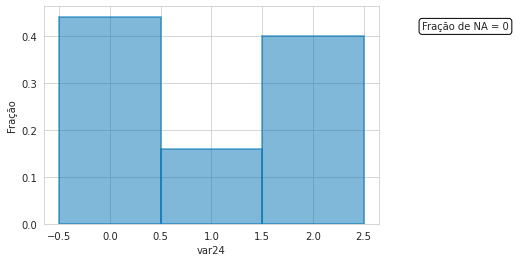

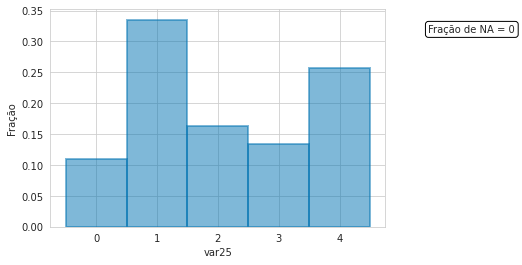

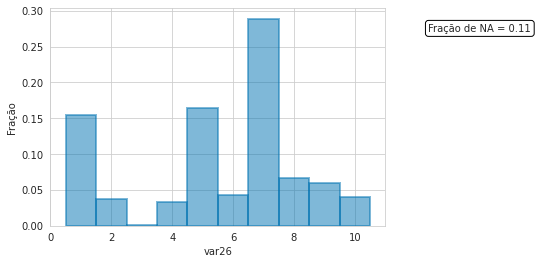

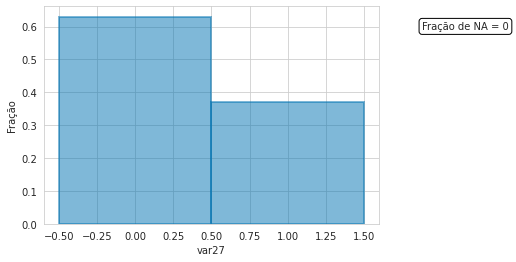

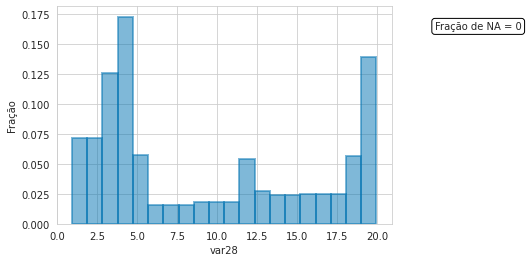

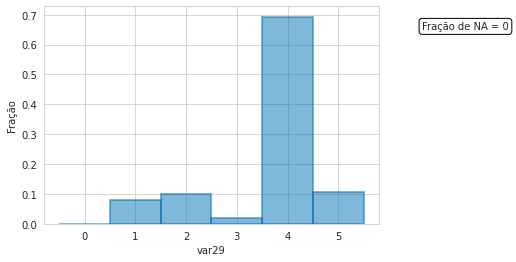

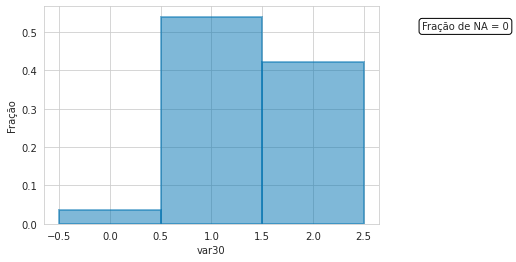

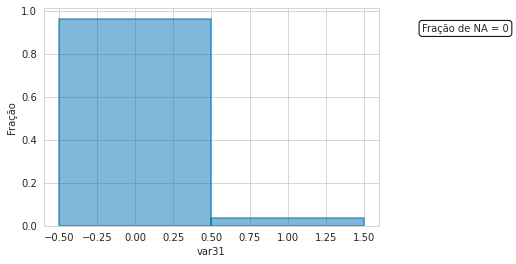

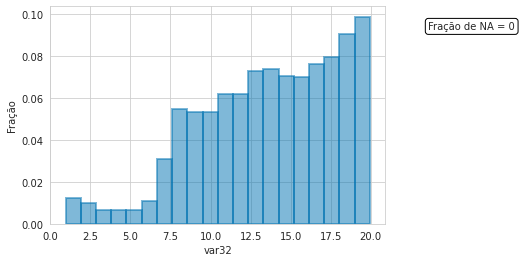

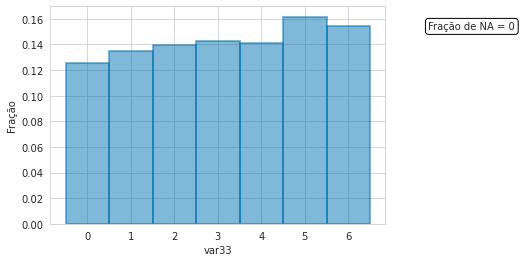

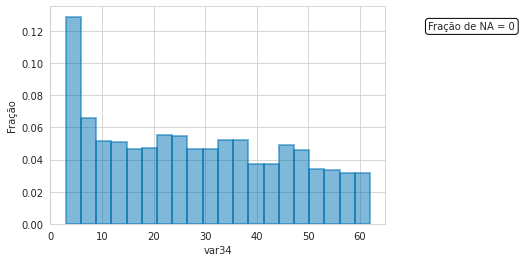

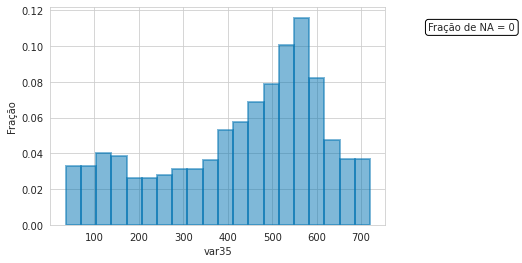

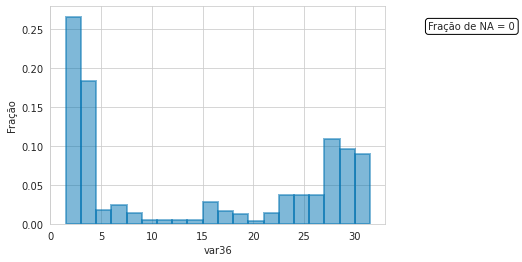

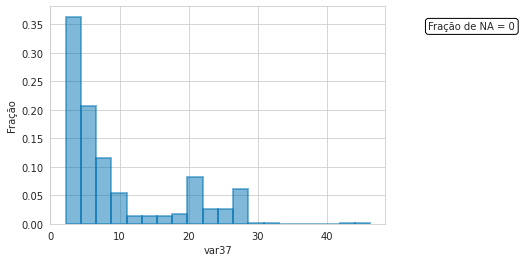

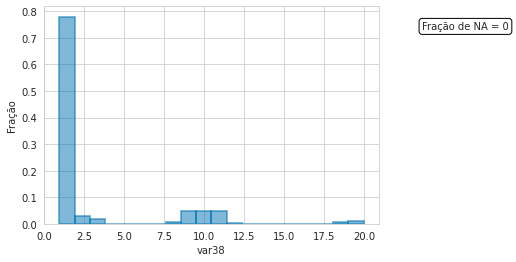

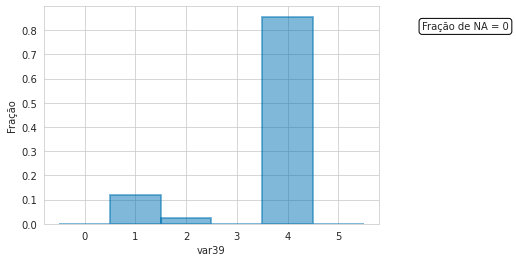

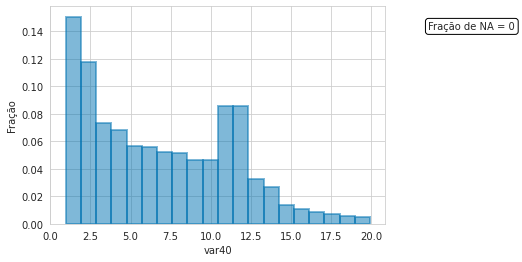

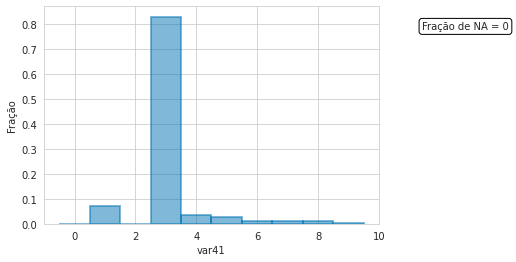

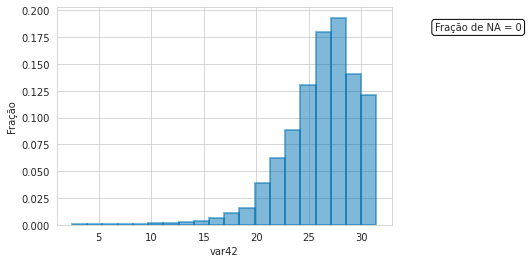

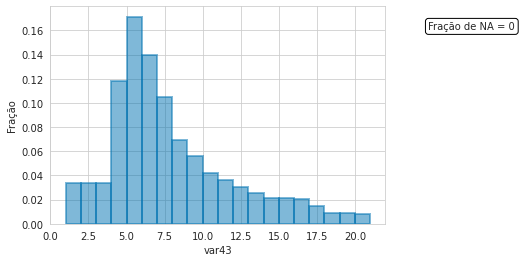

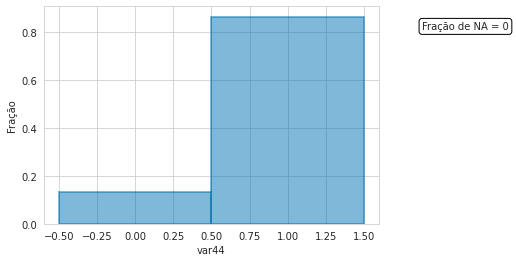

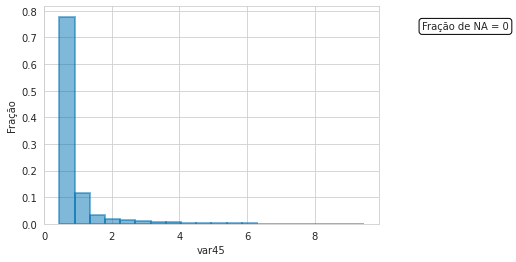

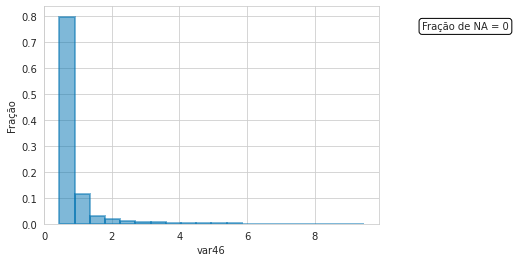

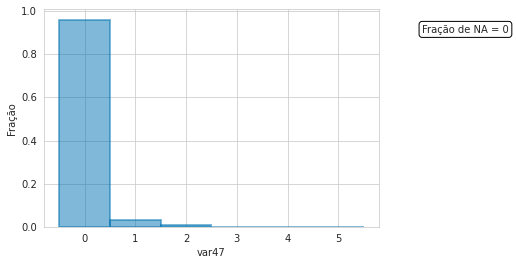

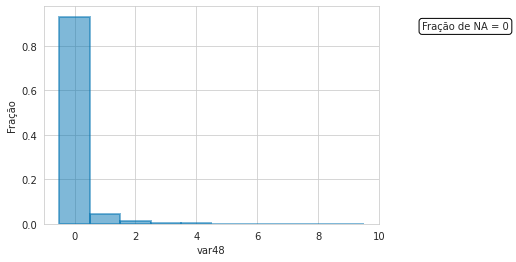

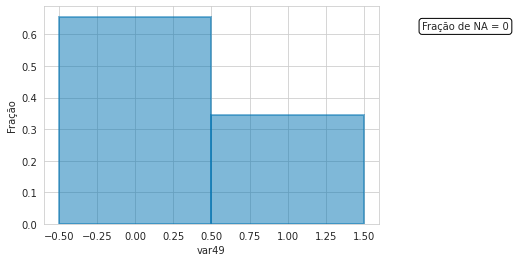

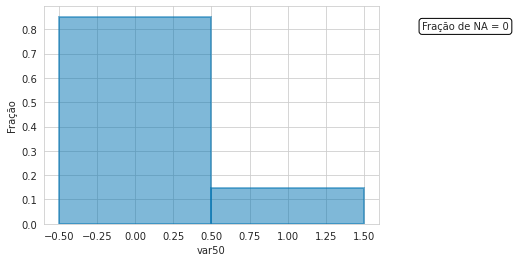

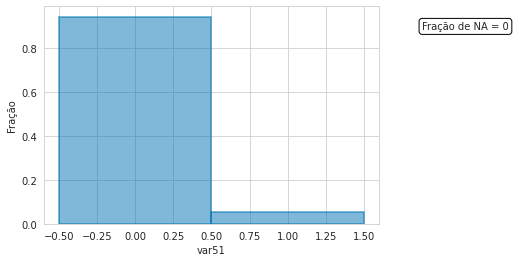

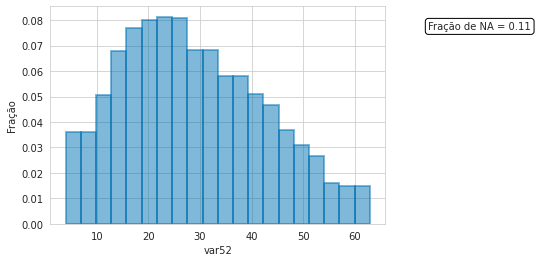

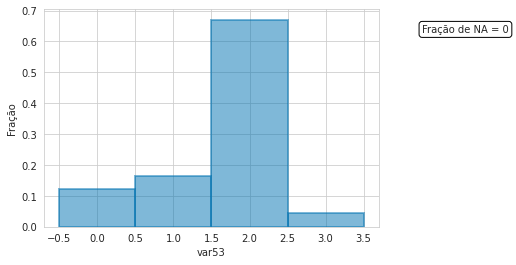

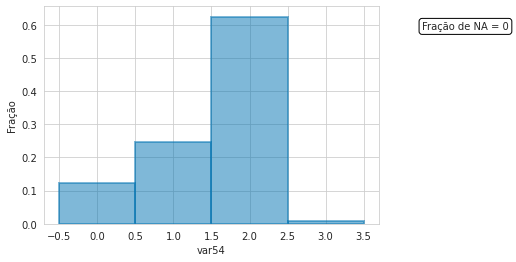

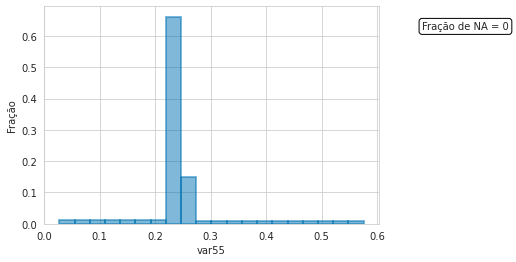

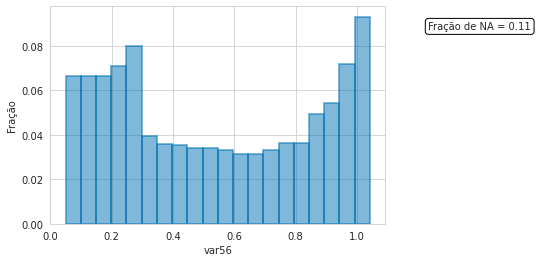

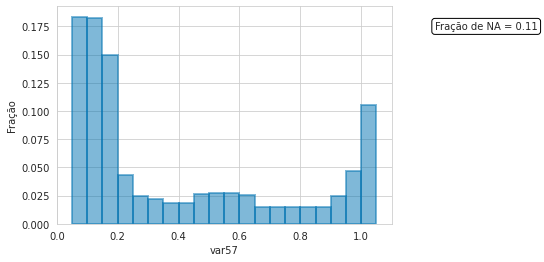

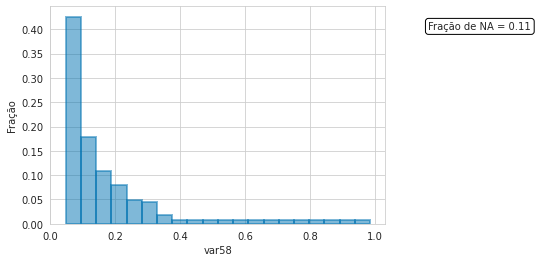

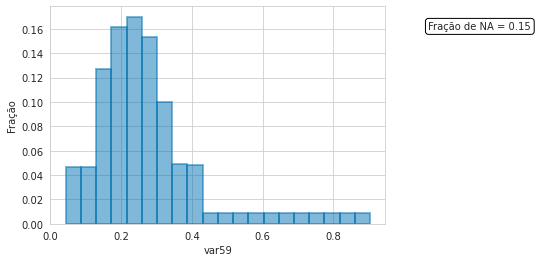

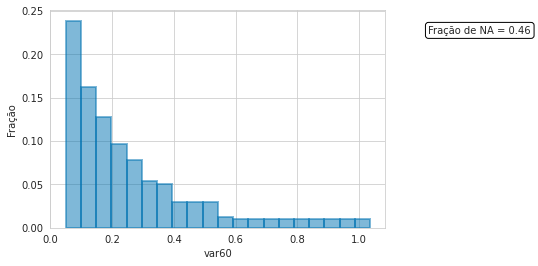

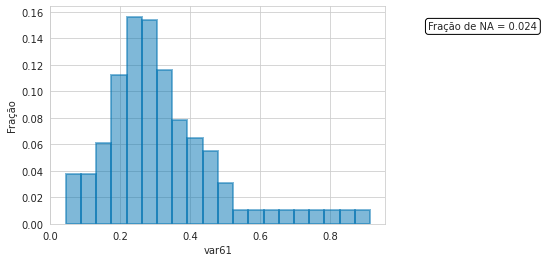

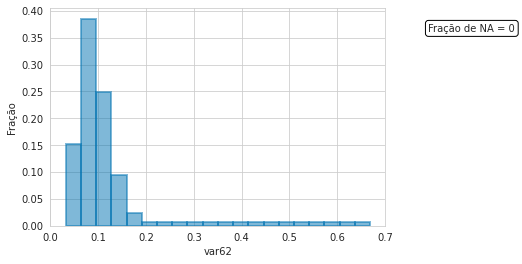

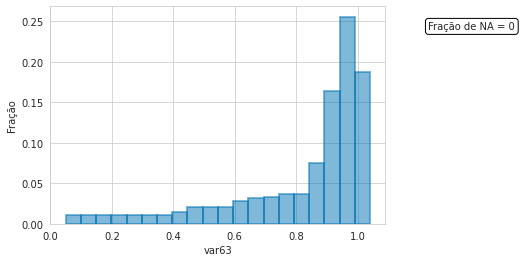

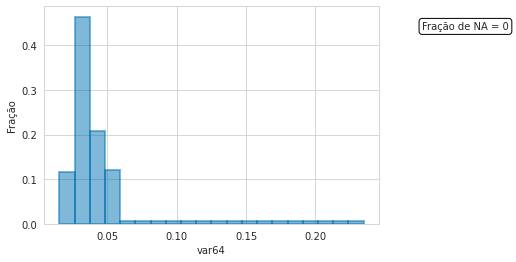

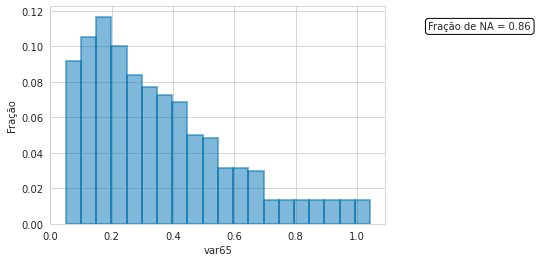

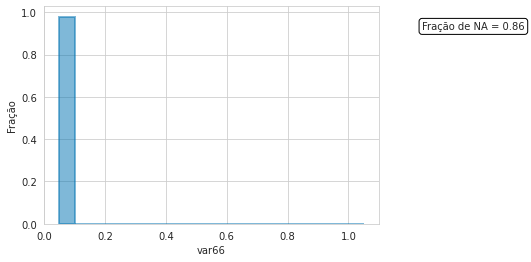

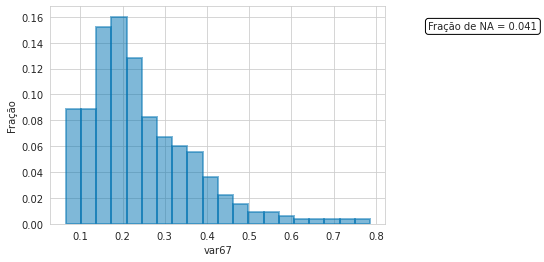

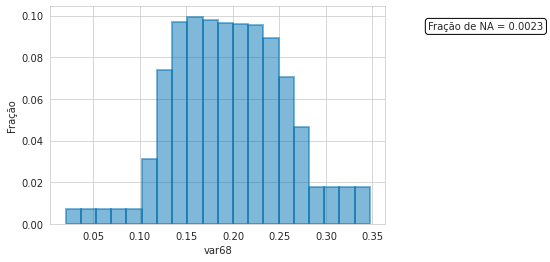

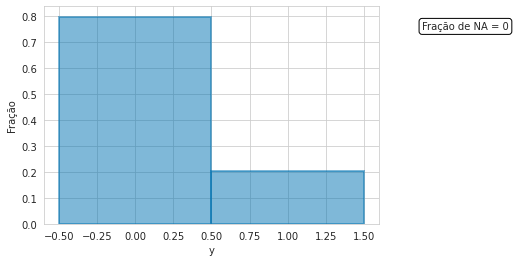

In [17]:
analiseexp.grafico_distribuicao(bins = 20)

In [18]:
alvo = 'y'

In [19]:
colunas_id = ['id']

#Tratamento dos Nulos

In [20]:
cols_tot = df.drop(colunas_id, axis = 1).drop(alvo, axis = 1)
dict_imputer = {}
dict_media = {}
dict_desvio = {}
for col in cols_tot:
  df['nulo_' + col] = np.where(df[col].isna(), 1, 0)
  dict_imputer[col] = df[col].dropna().mean()
  dict_media[col] = df[col].dropna().mean()
  dict_desvio[col] = df[col].dropna().std()
  #df[col] = df[col].fillna(dict_imputer[col])

# Separação do Teste (SAGRADO!)

In [21]:
frac_teste = 0.0

if(frac_teste == 0):
  df_intermed = df
else:
  ss_teste = StratifiedShuffleSplit(n_splits = 1, test_size = frac_teste, random_state = 42)
  split_teste = list(ss_teste.split(df.values, df[alvo].values))[0] 

  df_intermed = df.iloc[split_teste[0]]
  df_teste = df.iloc[split_teste[1]]

  print(len(df_teste))

# Separação Conjuntos Treino/Validação

In [22]:
#Vamos estimar qual a proporção que temos de exemplos desconhecidos
f = len(pd.read_csv('test.csv.zip'))/(len(pd.read_csv('test.csv.zip')) + len(df_intermed))

In [23]:
frac_val = f ##0.1 #0.25
num_splits = 100 #50 ##10

ss = StratifiedShuffleSplit(n_splits = num_splits, test_size = frac_val, random_state = 42)
#ss = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = 42)
lista_splits = list(ss.split(df_intermed.values, df_intermed[alvo].values))

In [24]:
inverter_conjuntos = False

dict_Xy = {}

i = 0
for par in lista_splits:
    df_treino = df_intermed.iloc[par[0]]
    df_val = df_intermed.iloc[par[1]]
    
    dict_Xy.update({'Treino_' + str(i + 1): (df_treino.drop(colunas_id, axis = 1).drop(alvo, axis = 1), df_treino[alvo]),
               'Validacao_' + str(i + 1): (df_val.drop(colunas_id, axis = 1).drop(alvo, axis = 1), df_val[alvo])})
    
    if(inverter_conjuntos):
      tam = len(lista_splits)
      dict_Xy.update({'Treino_' + str(tam + i + 1): (df_val.drop(colunas_id, axis = 1).drop(alvo, axis = 1), df_val[alvo]),
                'Validacao_' + str(tam + i + 1): (df_treino.drop(colunas_id, axis = 1).drop(alvo, axis = 1), df_treino[alvo])})
    
    i = i + 1

In [25]:
dict_Xy.keys()

dict_keys(['Treino_1', 'Validacao_1', 'Treino_2', 'Validacao_2', 'Treino_3', 'Validacao_3', 'Treino_4', 'Validacao_4', 'Treino_5', 'Validacao_5', 'Treino_6', 'Validacao_6', 'Treino_7', 'Validacao_7', 'Treino_8', 'Validacao_8', 'Treino_9', 'Validacao_9', 'Treino_10', 'Validacao_10', 'Treino_11', 'Validacao_11', 'Treino_12', 'Validacao_12', 'Treino_13', 'Validacao_13', 'Treino_14', 'Validacao_14', 'Treino_15', 'Validacao_15', 'Treino_16', 'Validacao_16', 'Treino_17', 'Validacao_17', 'Treino_18', 'Validacao_18', 'Treino_19', 'Validacao_19', 'Treino_20', 'Validacao_20', 'Treino_21', 'Validacao_21', 'Treino_22', 'Validacao_22', 'Treino_23', 'Validacao_23', 'Treino_24', 'Validacao_24', 'Treino_25', 'Validacao_25', 'Treino_26', 'Validacao_26', 'Treino_27', 'Validacao_27', 'Treino_28', 'Validacao_28', 'Treino_29', 'Validacao_29', 'Treino_30', 'Validacao_30', 'Treino_31', 'Validacao_31', 'Treino_32', 'Validacao_32', 'Treino_33', 'Validacao_33', 'Treino_34', 'Validacao_34', 'Treino_35', 'Validac

# Filtro de Features Instáveis entre os Conjuntos

In [26]:
estabilidade_validacao = False

for i in range(0,int(len(dict_Xy)/2)):

  indices_temp = dict_Xy['Treino_'+str(i+1)][0].index
  analise_ig_temp = aml.AvaliaClassificacao(df_intermed.loc[indices_temp, :].drop(colunas_id, axis = 1), alvo, col_prob = None, num_div = 10, num_cat = 5)
  analise_ig_temp.calcula_metricas_condicionais(df_intermed.loc[indices_temp, :].drop(colunas_id, axis = 1))
  if(i == 0):
    df_igs = pd.DataFrame(analise_ig_temp.ganho_info(), columns = ['Treino_'+str(i+1)])
  else:
    df_igs = pd.concat((df_igs, pd.DataFrame(analise_ig_temp.ganho_info(), columns = ['Treino_'+str(i+1)])), axis = 1)

  if(estabilidade_validacao):
    indices_temp = dict_Xy['Validacao_'+str(i+1)][0].index
    analise_ig_temp = aml.AvaliaClassificacao(df_intermed.loc[indices_temp, :].drop(colunas_id, axis = 1), alvo, col_prob = None, num_div = 10, num_cat = 5)
    analise_ig_temp.calcula_metricas_condicionais(df_intermed.loc[indices_temp, :].drop(colunas_id, axis = 1))
    df_igs = pd.concat((df_igs, pd.DataFrame(analise_ig_temp.ganho_info(), columns = ['Validacao_'+str(i+1)])), axis = 1)

media = df_igs.mean(axis = 1)
desvio = df_igs.std(axis = 1)
df_igs['Media'] = media
df_igs['Desvio'] = desvio
df_igs['CoefVariacao'] = desvio/media
df_igs = df_igs[['Media', 'Desvio', 'CoefVariacao']]
df_igs = df_igs.loc[df_igs.index != alvo, :]

df_igs = df_igs.sort_values('Media', ascending = False)

In [27]:
df_igs

,Media,Desvio,CoefVariacao
var4,1.520502e-01,8.936508e-03,5.877342e-02
nulo_var8,1.090156e-01,7.585515e-03,6.958191e-02
nulo_var6,4.782726e-02,2.852443e-03,5.964053e-02
nulo_var7,4.743938e-02,2.996895e-03,6.317315e-02
var20,4.384984e-02,3.618344e-03,8.251668e-02
...,...,...,...
nulo_var42,-1.530235e-16,1.238805e-31,-8.095521e-16
nulo_var41,-1.530235e-16,1.238805e-31,-8.095521e-16
nulo_var40,-1.530235e-16,1.238805e-31,-8.095521e-16
nulo_var39,-1.530235e-16,1.238805e-31,-8.095521e-16


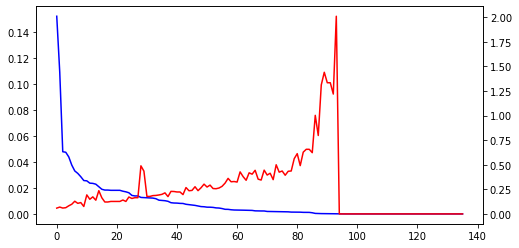

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(df_igs['Media'].values, color = 'blue')
ax2 = ax.twinx()
ax2.plot(df_igs['CoefVariacao'].values, color = 'red')
plt.show()

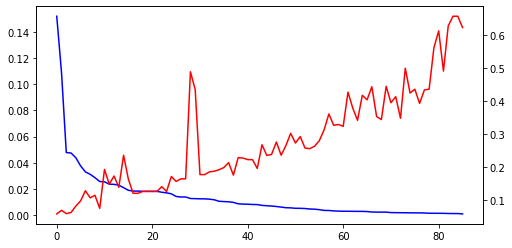

['var4', 'nulo_var8', 'nulo_var6', 'nulo_var7', 'var20', 'var23', 'var54', 'var1', 'var14', 'nulo_var4', 'var5', 'var53', 'var7', 'var24', 'var21', 'var8', 'nulo_var26', 'nulo_var58', 'nulo_var15', 'nulo_var16', 'nulo_var18', 'nulo_var17', 'var29', 'var22', 'var13', 'var28', 'nulo_var52', 'nulo_var9', 'var66', 'var65', 'nulo_var57', 'nulo_var56', 'nulo_var11', 'nulo_var59', 'nulo_var12', 'nulo_var10', 'var25', 'var50', 'var17', 'var56', 'var2', 'var57', 'var63', 'var52', 'var34', 'var6', 'var26', 'var27', 'var3', 'var59', 'var55', 'nulo_var60', 'var19', 'var58', 'var43', 'var40', 'var67', 'var12', 'var62', 'var64', 'var35', 'var60', 'var61', 'var36', 'var15', 'var16', 'var10', 'var38', 'var11', 'var42', 'var32', 'var45', 'var48', 'var9', 'var37', 'var39', 'var41', 'var46', 'var68', 'var18', 'nulo_var67', 'var33', 'var51', 'nulo_var2', 'nulo_var3', 'var47']
86


In [29]:
num_max_features = 90 #60 #50
limiar_coef_var = 0.7 #0.1 #0.15

df_igs_filter = df_igs.iloc[:num_max_features]
df_igs_filter = df_igs_filter[(df_igs_filter['CoefVariacao'] <= limiar_coef_var) & (~df_igs_filter['CoefVariacao'].isna())]

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(df_igs_filter['Media'].values, color = 'blue')
ax2 = ax.twinx()
ax2.plot(df_igs_filter['CoefVariacao'].values, color = 'red')
plt.show()

cols_modelo = list(df_igs_filter.index)
print(cols_modelo)
print(len(cols_modelo))

In [30]:
dict_Xy_modelo = dict_Xy.copy()

for key in dict_Xy_modelo.keys():
  dict_Xy_modelo[key] = (dict_Xy_modelo[key][0][cols_modelo], dict_Xy_modelo[key][1])

# Catboost - CrossVal para Decidir o Melhor número de iterações

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0


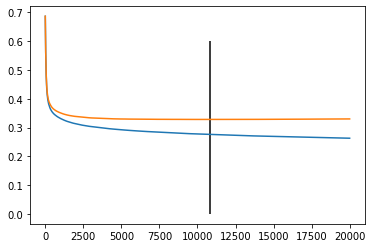

1


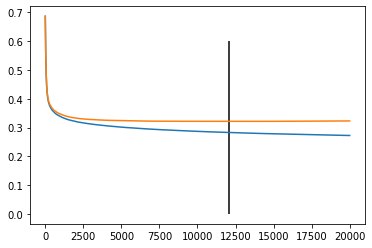

2


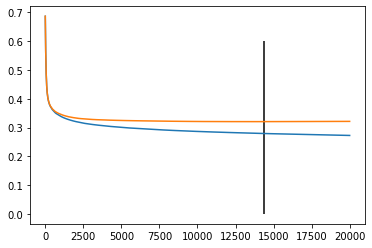

3


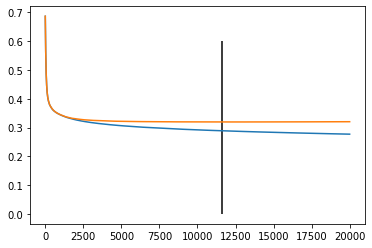

4


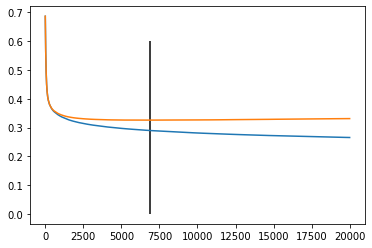

5


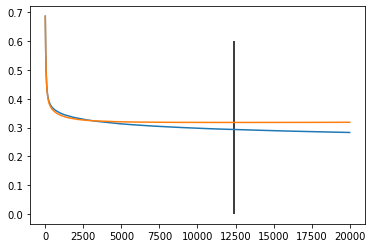

6


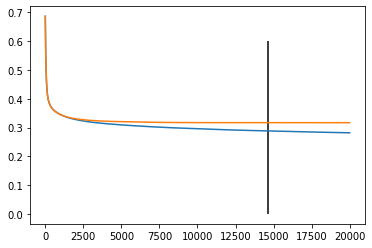

7


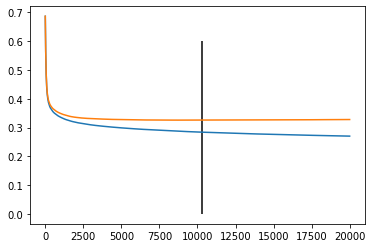

8


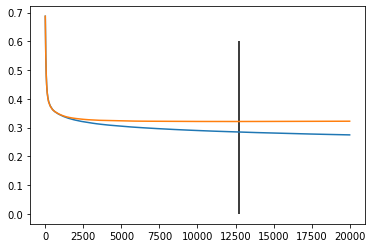

9


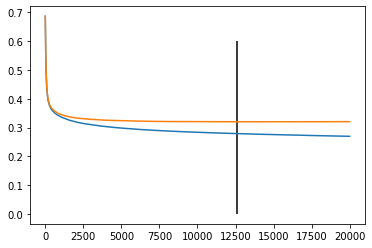

10


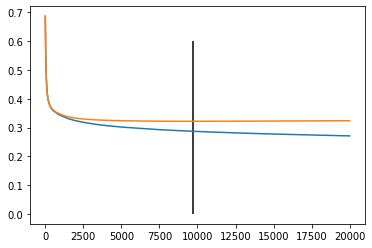

11


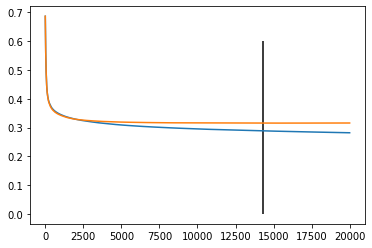

12


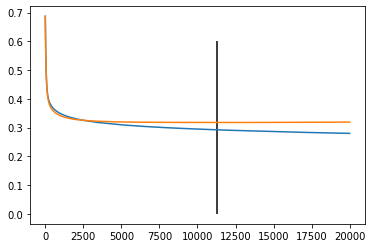

13


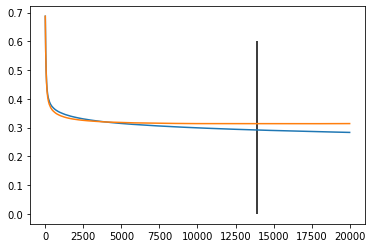

14


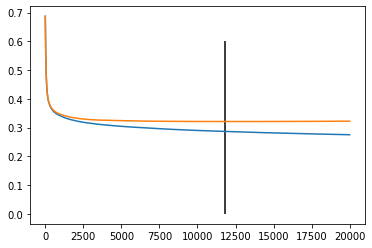

15


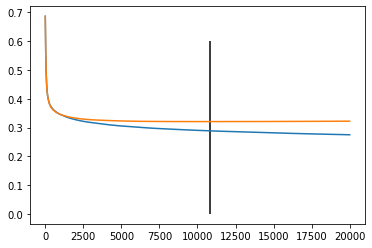

16


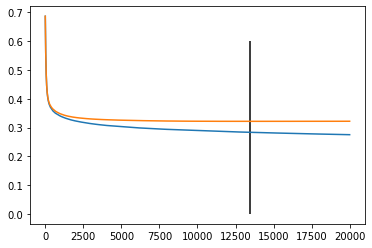

17


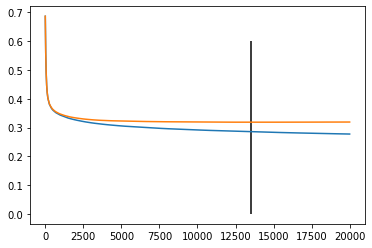

18


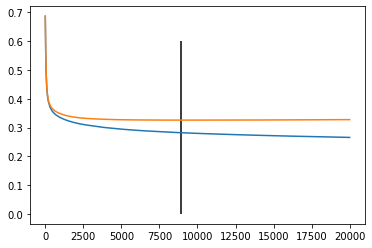

19


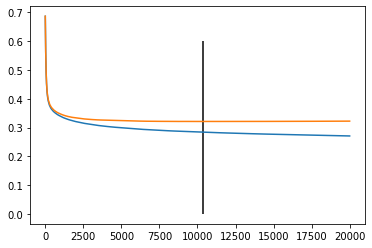

20


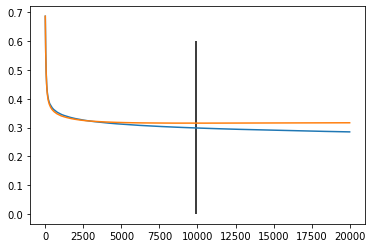

21


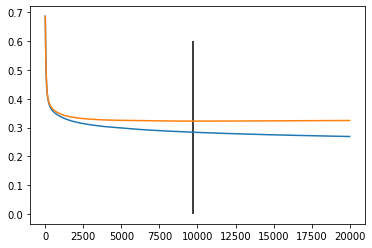

22


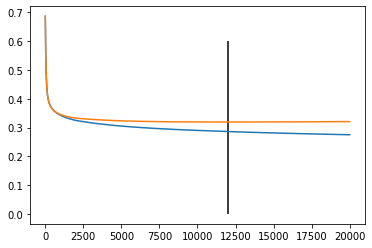

23


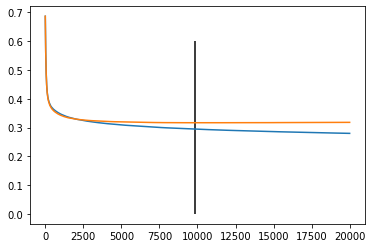

24


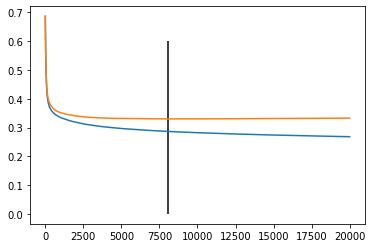

25


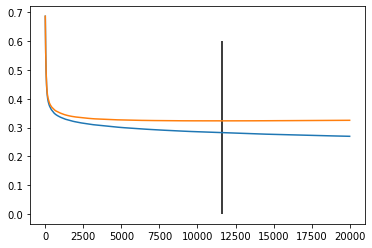

26


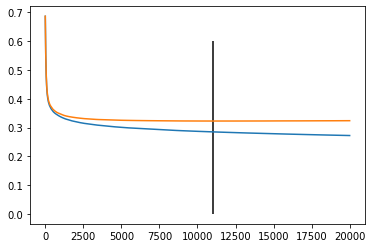

27


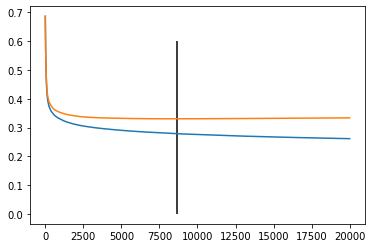

28


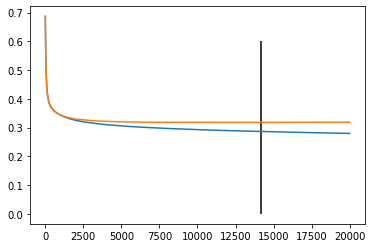

29


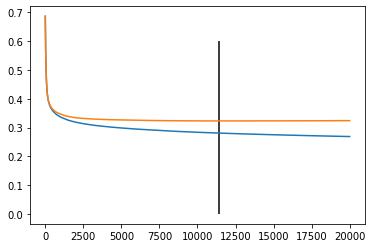

30


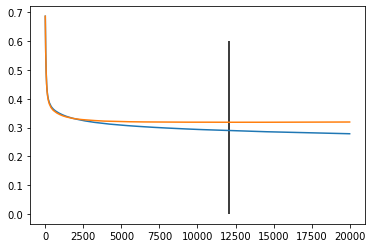

31


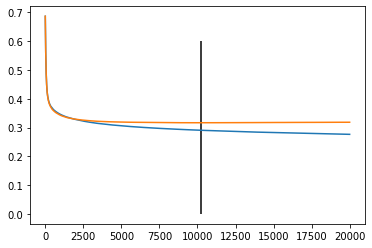

32


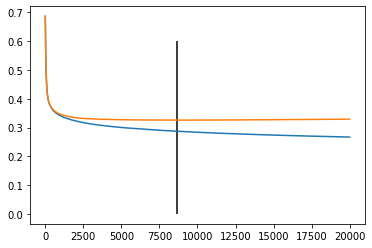

33


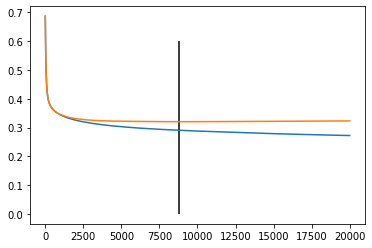

34


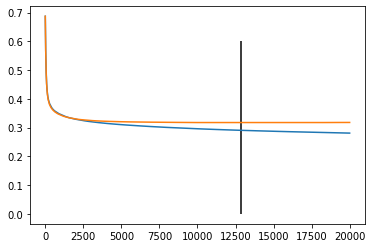

35


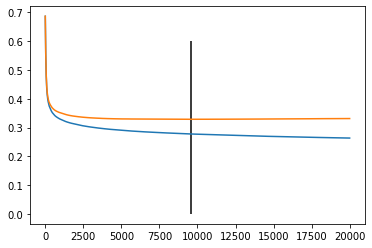

36


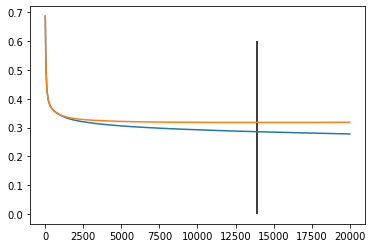

37


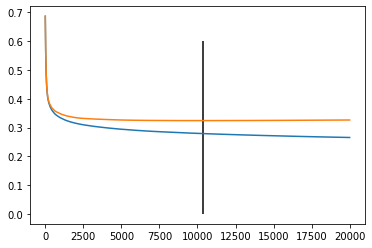

38


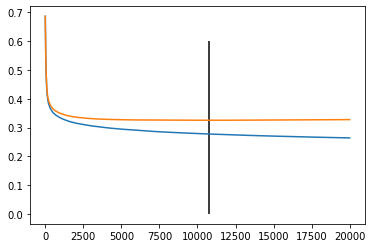

39


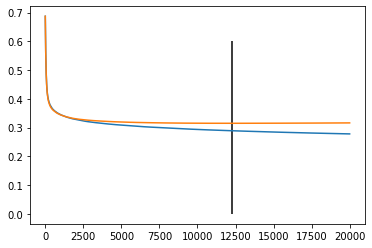

40


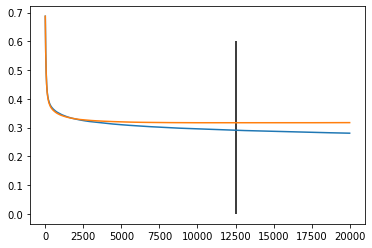

41


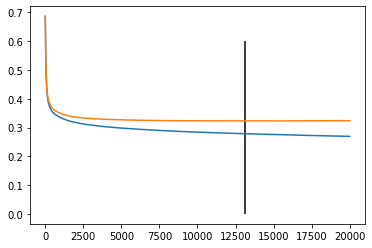

42


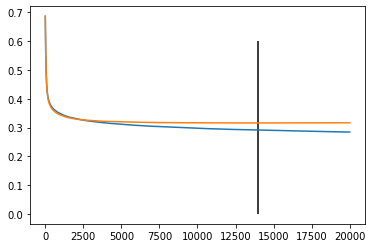

43


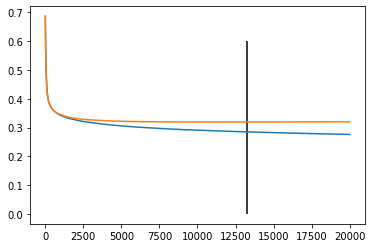

44


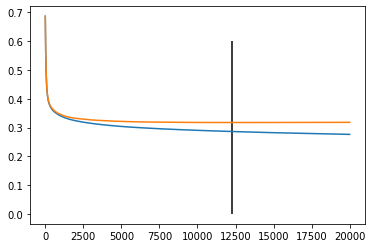

45


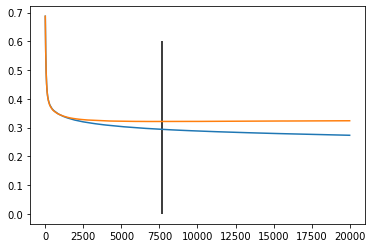

46


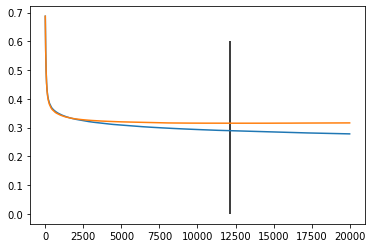

47


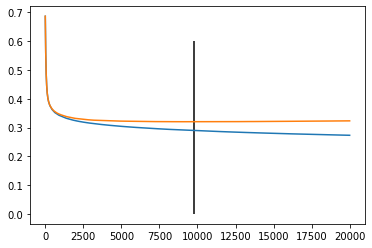

48


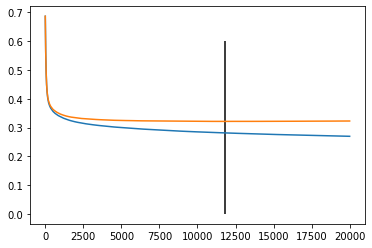

49


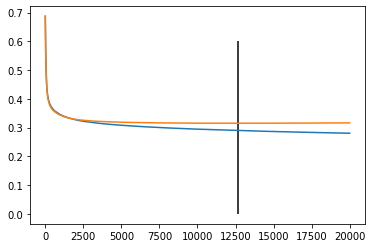

50


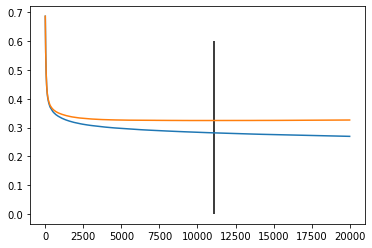

51


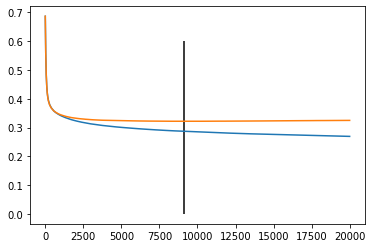

52


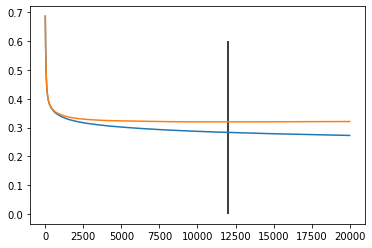

53


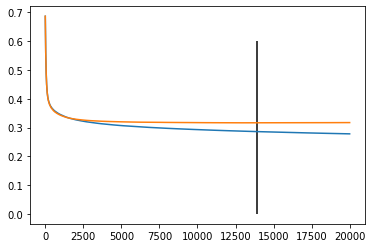

54


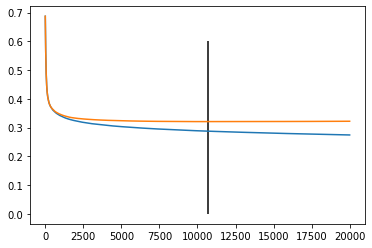

55


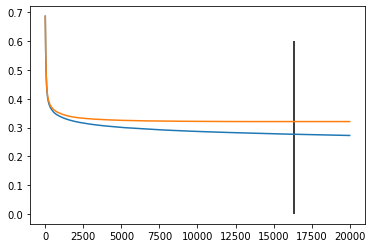

56


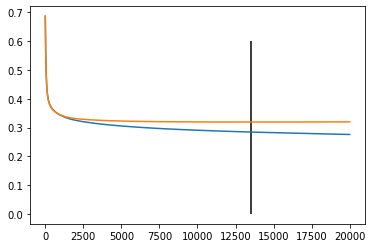

57


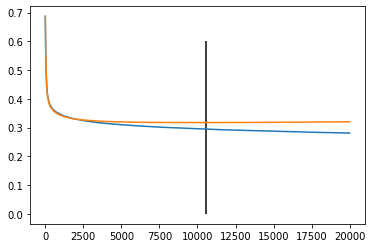

58


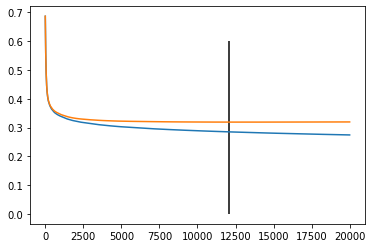

59


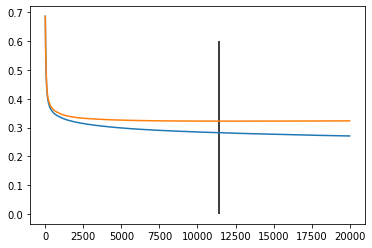

60


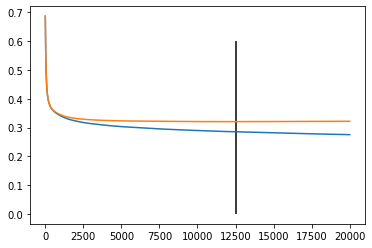

61


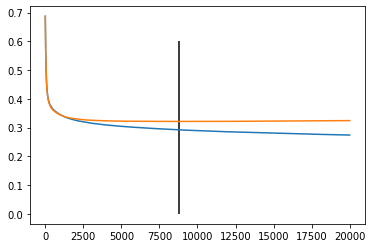

62


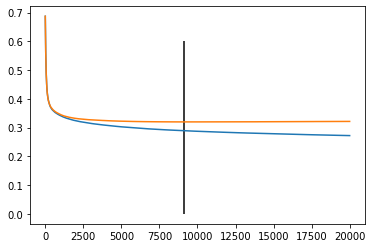

63


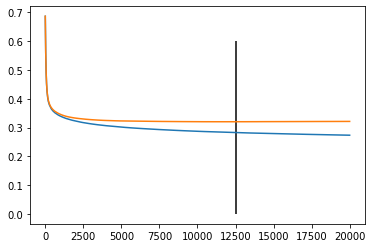

64


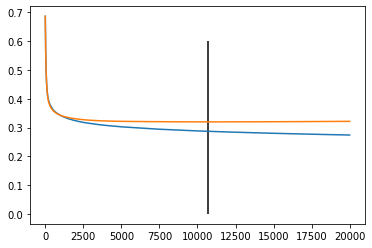

65


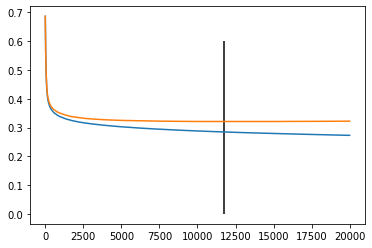

66


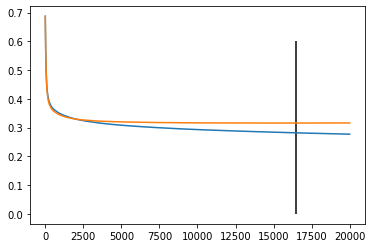

67


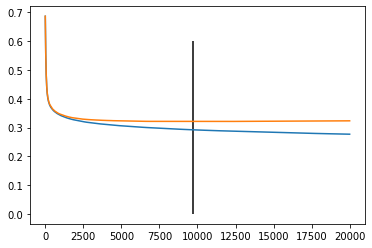

68


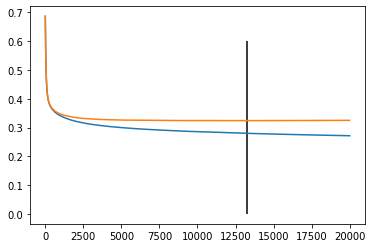

69


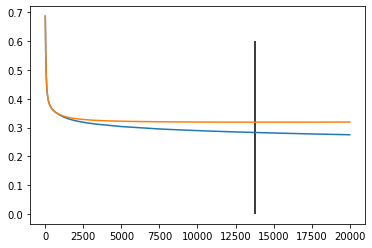

70


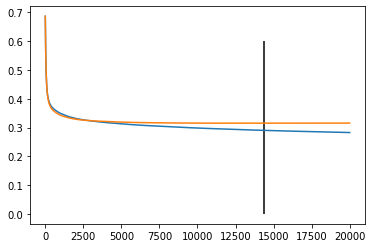

71


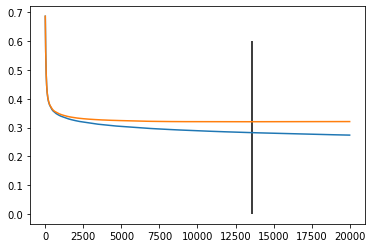

72


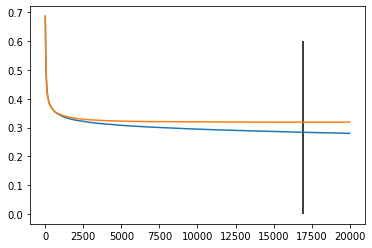

73


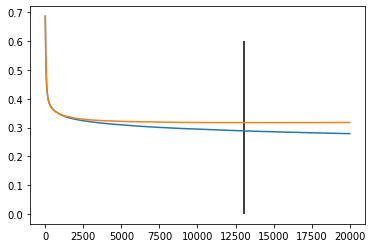

74


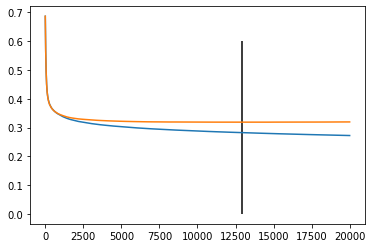

75


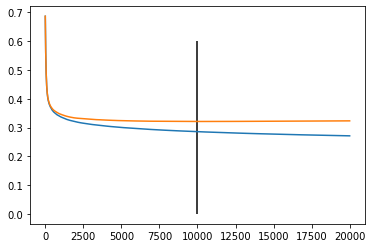

76


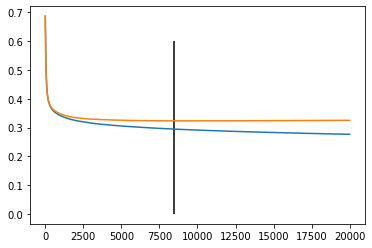

77


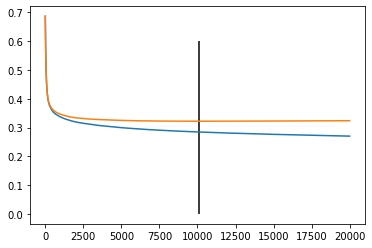

78


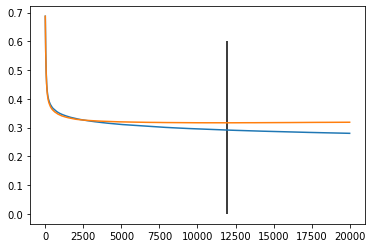

79


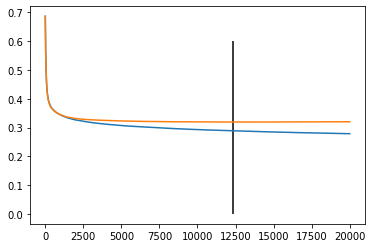

80


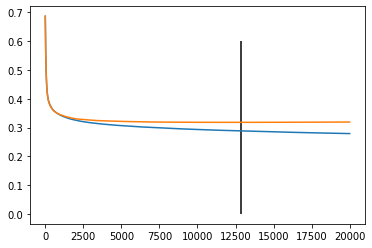

81


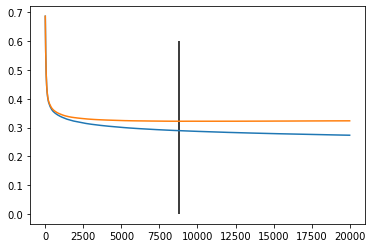

82


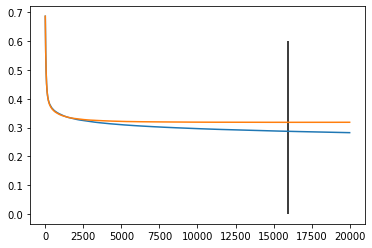

83


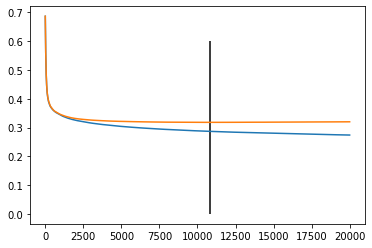

84


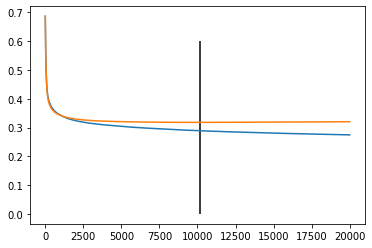

85


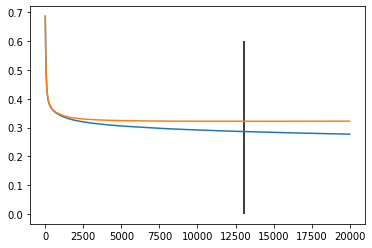

86


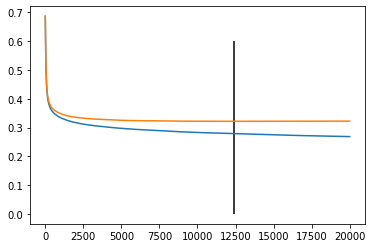

87


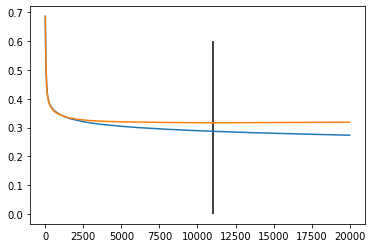

88


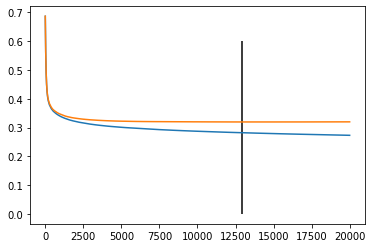

89


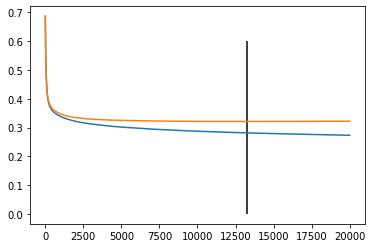

90


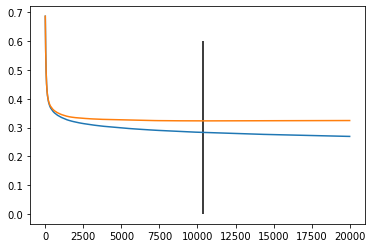

91


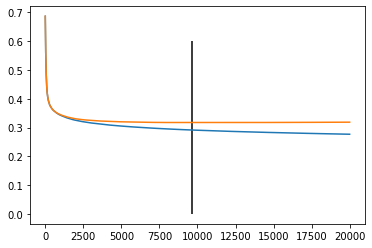

92


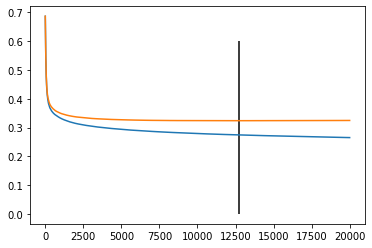

93


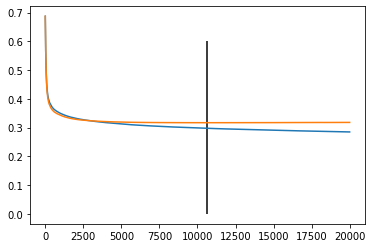

94


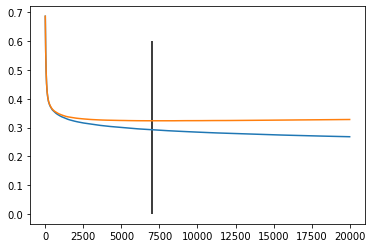

95


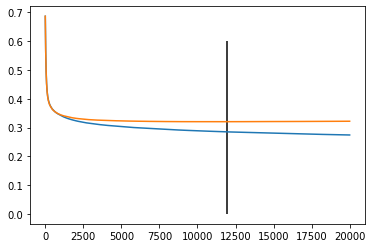

96


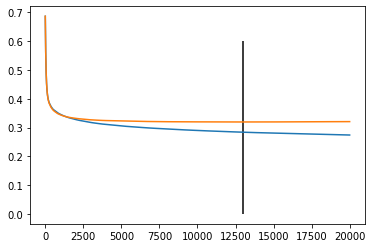

97


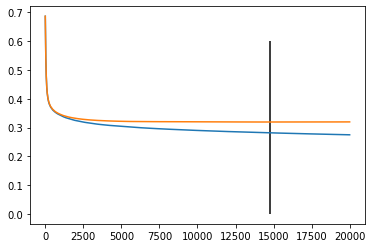

98


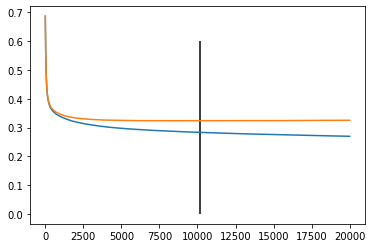

99


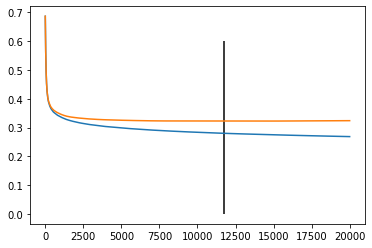

['/content/drive/MyDrive/Desafio_Kaggle/clf_list3.pkl']

In [33]:
clf_list = []
best_iteration_list = []

for i in range(0,int(len(dict_Xy_modelo)/2)):

  clf = CatBoostClassifier(iterations = 20000, learning_rate = 0.01, depth = 1, 
                           eval_metric = 'Logloss', loss_function = 'Logloss')

  eval_set = [dict_Xy_modelo['Treino_'+str(i+1)], dict_Xy_modelo['Validacao_'+str(i+1)]]
  clf.fit(dict_Xy_modelo['Treino_'+str(i+1)][0], dict_Xy_modelo['Treino_'+str(i+1)][1], eval_set = eval_set, 
          early_stopping_rounds = None, verbose = False)

  clf_list.append(clf)
  best_iteration_list.append(clf.get_best_iteration())

  print(i)
  plt.plot(clf.evals_result_['validation_0']['Logloss'])
  plt.plot(clf.evals_result_['validation_1']['Logloss'])
  plt.vlines(clf.get_best_iteration(), 0, 0.6)
  plt.show()

joblib.dump(best_iteration_list, path_notebook + 'best_iteration_list3.pkl')
joblib.dump(clf_list, path_notebook + 'clf_list3.pkl')

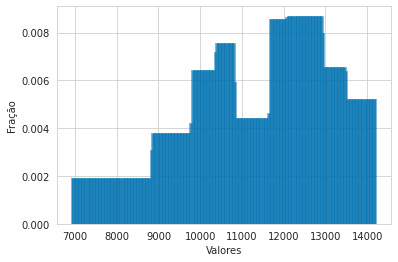

11665


In [31]:
best_iteration_list = joblib.load(path_notebook + 'best_iteration_list3.pkl')
clf_list = joblib.load(path_notebook + 'clf_list3.pkl')

dist_iterations = trf.CortaIntervalosQuasiUniforme(np.array(best_iteration_list), num_div = 10)
dist_iterations.grafico_distribuicao(bins = 200)

vetor_iters, vetor_fracs, _ = dist_iterations.curva_distribuicao(bins = 200)
vetor_fracs_acum = np.cumsum(vetor_fracs)

ind_inter_moda = np.sum(vetor_fracs_acum < 0.5)
if(vetor_fracs_acum[ind_inter_moda] == 0.5):
  max_iter = round(vetor_iters[ind_inter_moda])
else:
  max_iter = round((vetor_iters[ind_inter_moda] + vetor_iters[ind_inter_moda-1])/2)

print(max_iter)

#Nova Feature Selection

In [32]:
list_df_imp = []

for i in range(0,int(len(dict_Xy_modelo)/2)):

  clf = clf_list[i]

  df_val = dict_Xy_modelo['Validacao_'+str(i+1)][0].copy()
  df_val[alvo] = dict_Xy_modelo['Validacao_'+str(i+1)][1]

  explic_imp = exp.ImportanciaVariaveisClassificacao(clf, df_val, alvo, cols_features = cols_modelo, num_loop = 5, random_state = 42)
  df_logloss = pd.DataFrame(pd.Series(explic_imp.retorna_piora_logloss()), columns = ['Piora_Logloss'])

  print(i)
  #display(df_logloss)
  list_df_imp.append(df_logloss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [33]:
df_imp_concat = pd.concat(list_df_imp, axis = 1)
qtd_neg = (df_imp_concat < 0).sum(axis = 1)
qtd_pos = (df_imp_concat > 0).sum(axis = 1)
qtd_zero = (df_imp_concat == 0).sum(axis = 1)
media = df_imp_concat.mean(axis = 1)
desvio = df_imp_concat.std(axis = 1)
df_imp_concat['QTD_Neg'] = qtd_neg
df_imp_concat['QTD_Pos'] = qtd_pos
df_imp_concat['QTD_Zero'] = qtd_zero
df_imp_concat['Media'] = media
df_imp_concat['Desvio'] = desvio
df_imp_concat = df_imp_concat[['Media', 'Desvio', 'QTD_Pos', 'QTD_Zero', 'QTD_Neg']]
df_imp_concat = df_imp_concat.sort_values('QTD_Pos', ascending = True)
display(df_imp_concat)

,Media,Desvio,QTD_Pos,QTD_Zero,QTD_Neg
nulo_var12,-2.044088e-06,0.000017,0,96,4
nulo_var56,-3.112854e-07,0.000003,0,99,1
nulo_var57,0.000000e+00,0.000000,0,100,0
nulo_var10,-3.585786e-07,0.000004,0,99,1
nulo_var4,0.000000e+00,0.000000,0,100,0
...,...,...,...,...,...
var54,1.046450e-02,0.002400,100,0,0
var23,4.910798e-03,0.003120,100,0,0
nulo_var8,1.590242e-02,0.005682,100,0,0
var32,1.557023e-03,0.000704,100,0,0


In [34]:
cols_modelo_fil = list(df_imp_concat[(df_imp_concat['QTD_Pos'] > 50) & (df_imp_concat['Media'] > 0)].sort_values('Media', ascending = False).index)
print(cols_modelo_fil)
print(len(cols_modelo_fil))

['var4', 'var8', 'var7', 'var1', 'var6', 'var56', 'var55', 'nulo_var8', 'var54', 'var50', 'var24', 'var2', 'var67', 'var23', 'var63', 'var3', 'var51', 'var52', 'var58', 'var43', 'var21', 'nulo_var2', 'var26', 'var32', 'var5', 'var64', 'var61', 'var27', 'var35', 'var42', 'var9', 'var13', 'var66', 'var29', 'var62', 'var14', 'nulo_var6', 'var34', 'var53', 'nulo_var3', 'var60', 'var22', 'nulo_var7', 'var20', 'var39', 'var59', 'var15', 'var19', 'var47', 'var41', 'nulo_var58', 'var17', 'var33', 'var16', 'nulo_var67', 'var65', 'var11', 'var68']
58


#Novo CrossVal

0


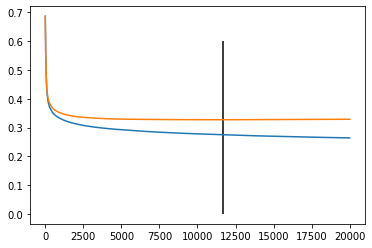

1


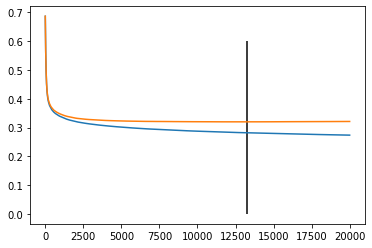

2


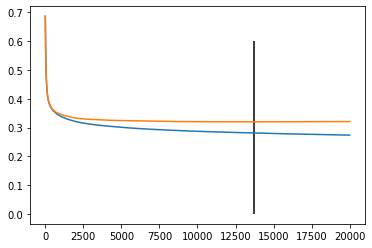

3


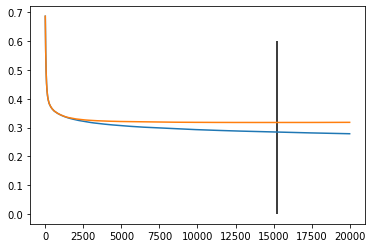

4


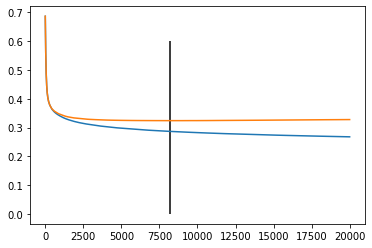

5


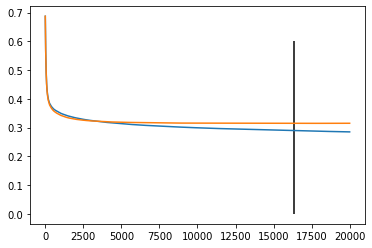

6


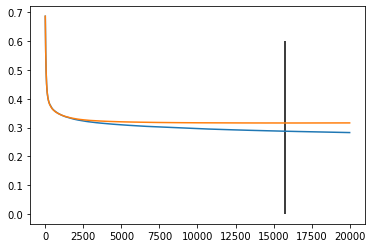

7


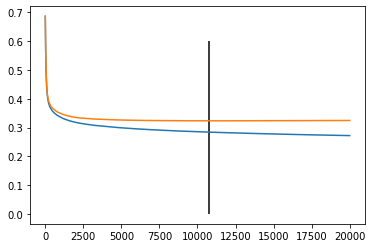

8


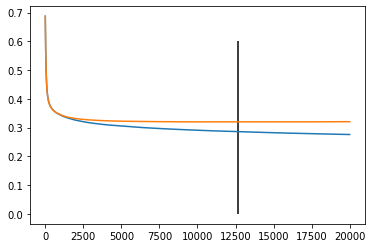

9


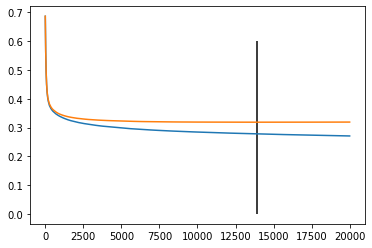

10


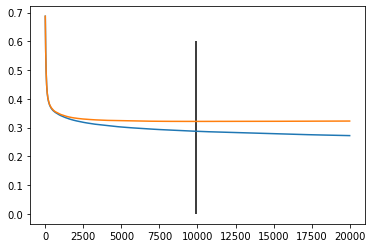

11


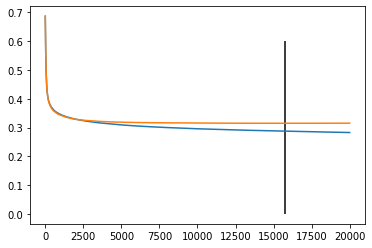

12


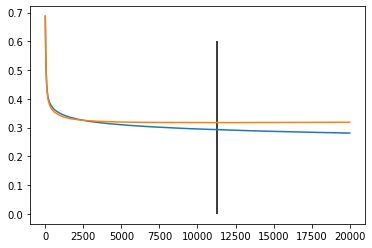

13


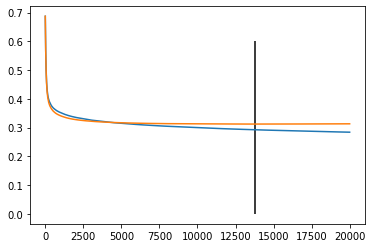

14


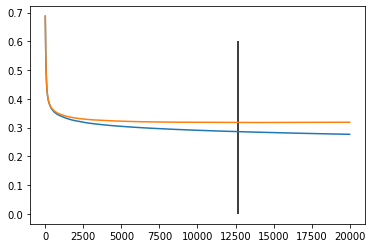

15


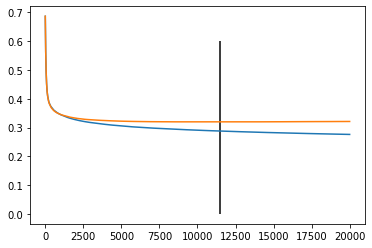

16


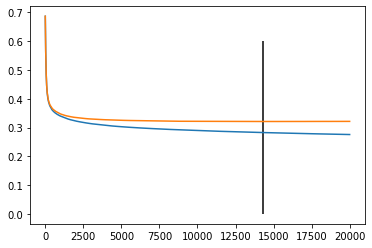

17


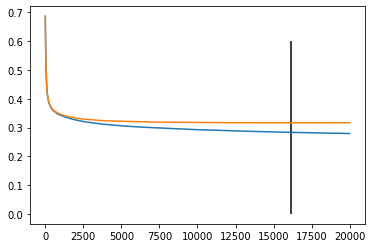

18


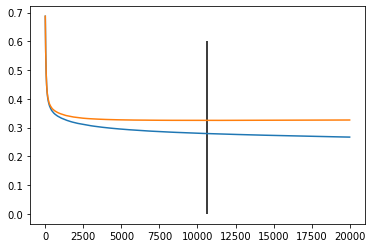

19


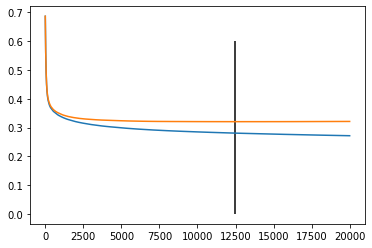

20


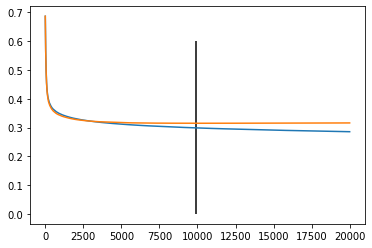

21


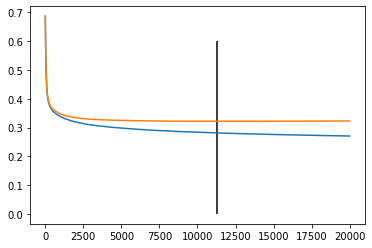

22


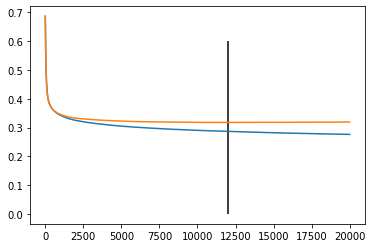

23


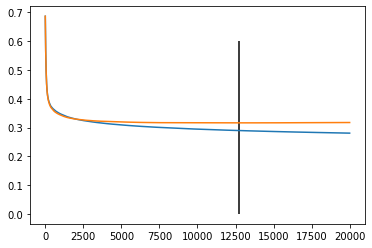

24


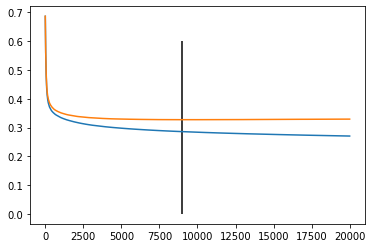

25


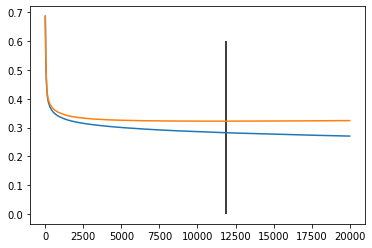

26


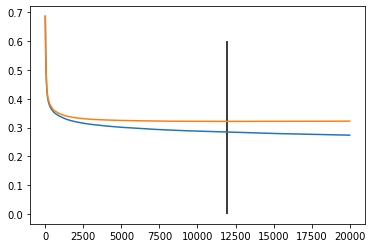

27


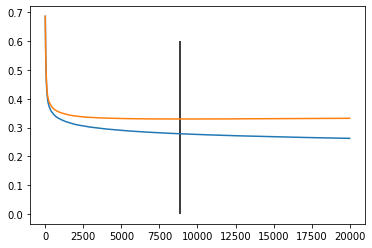

28


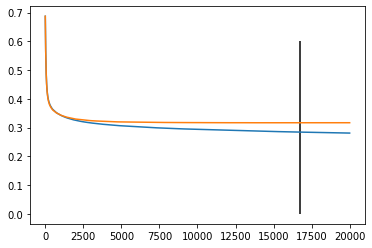

29


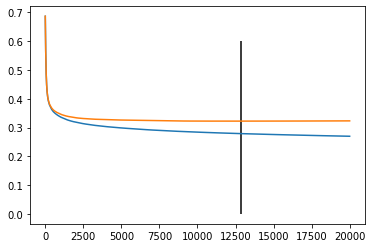

30


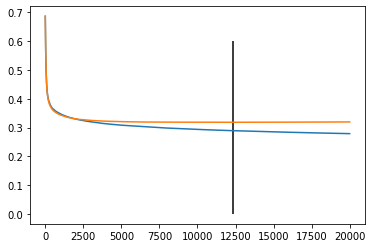

31


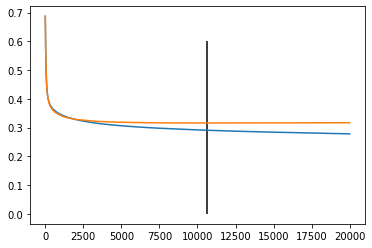

32


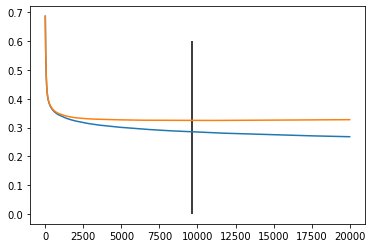

33


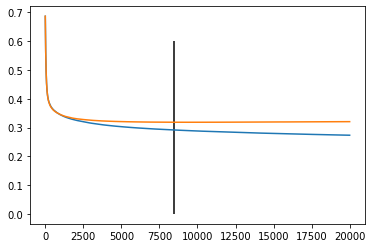

34


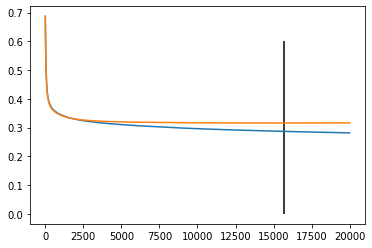

35


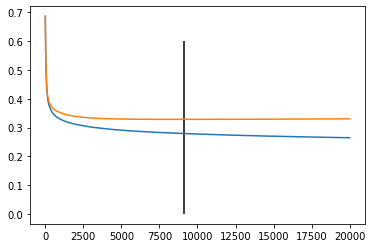

36


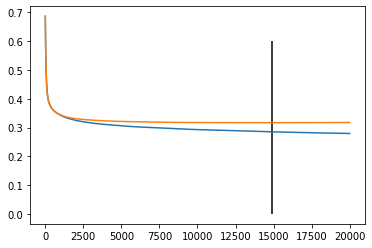

37


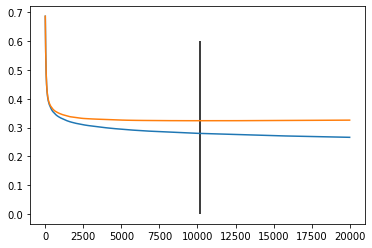

38


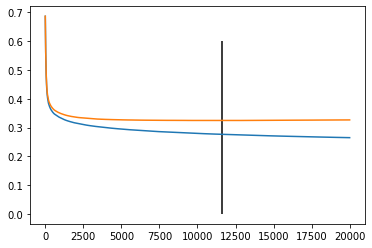

39


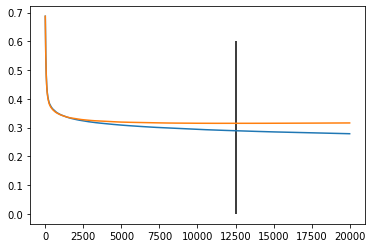

40


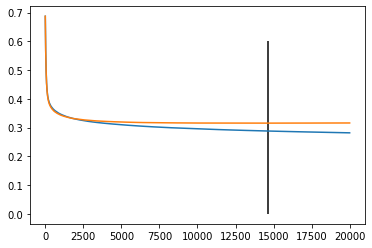

41


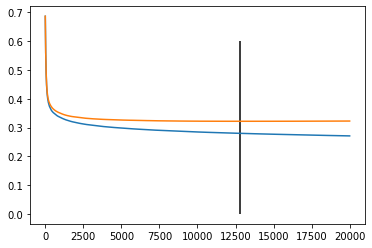

42


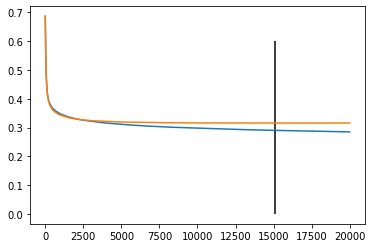

43


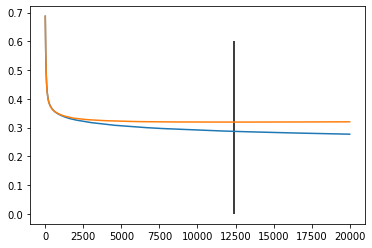

44


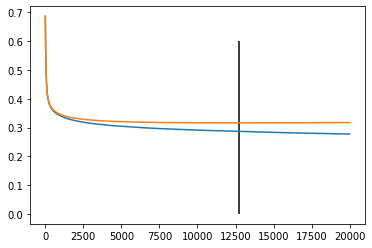

45


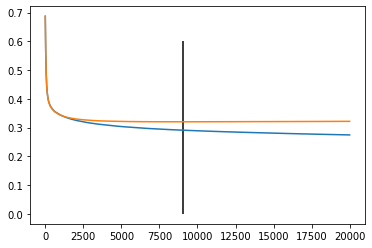

46


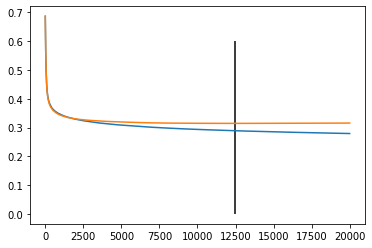

47


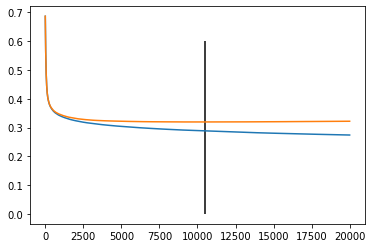

48


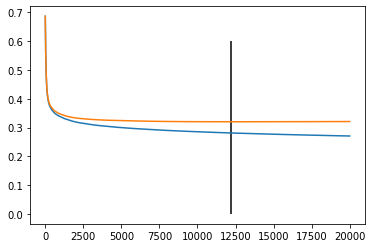

49


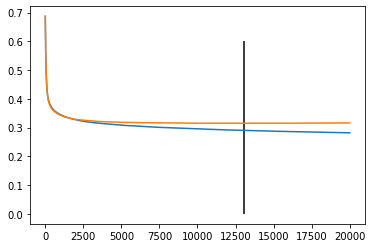

50


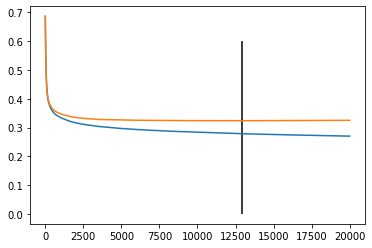

51


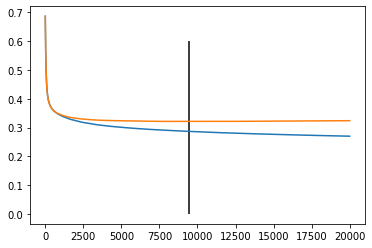

52


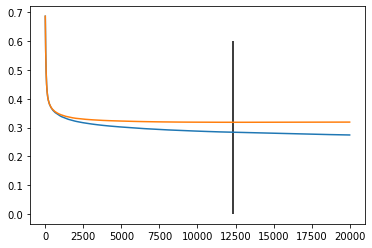

53


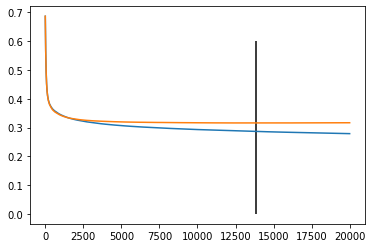

54


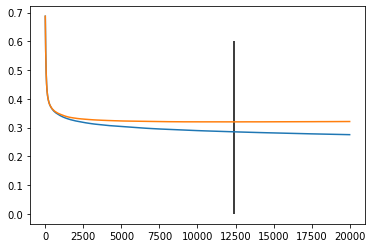

55


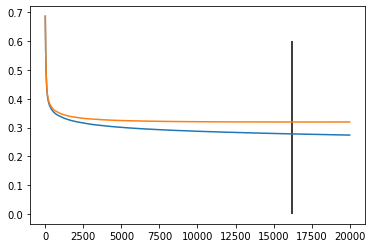

56


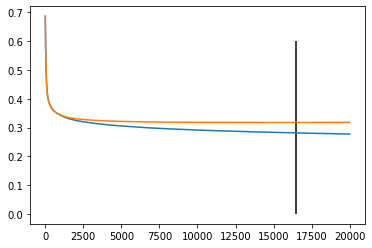

57


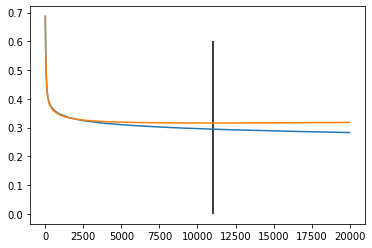

58


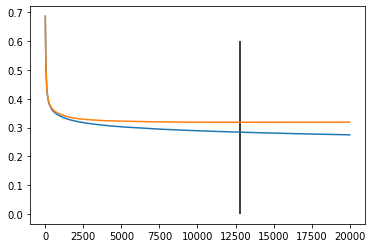

59


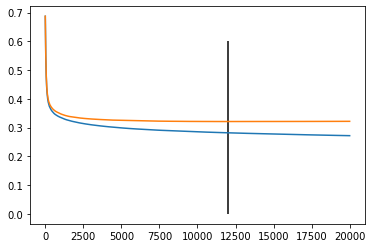

60


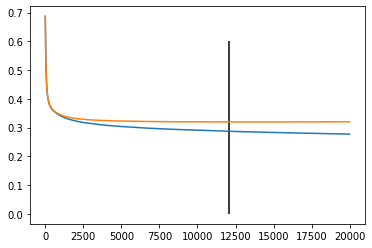

61


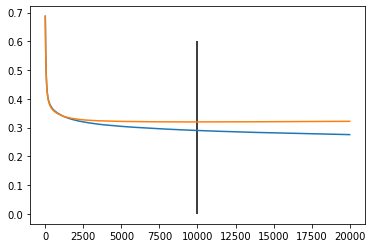

62


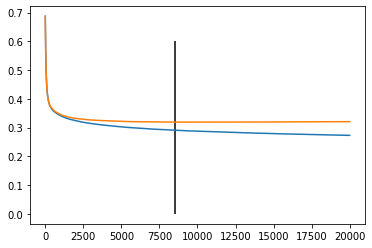

63


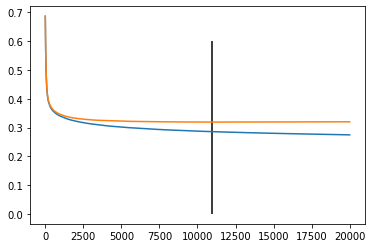

64


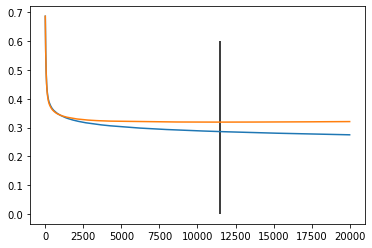

65


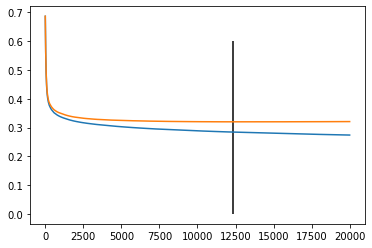

66


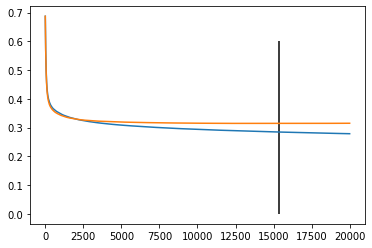

67


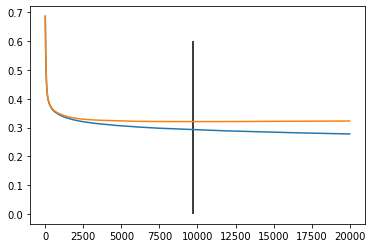

68


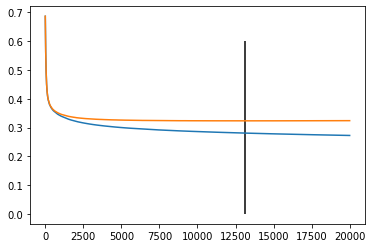

69


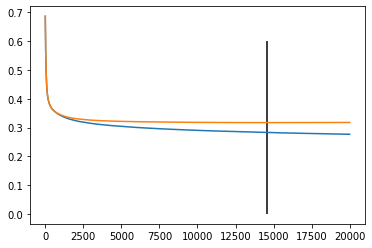

70


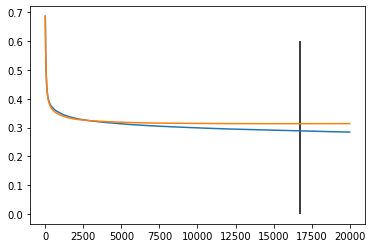

71


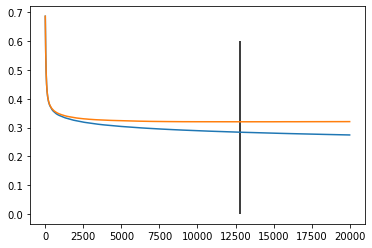

72


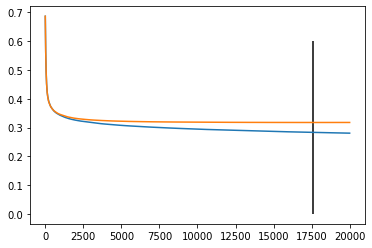

73


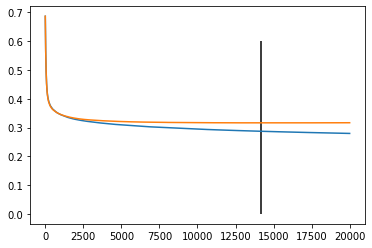

74


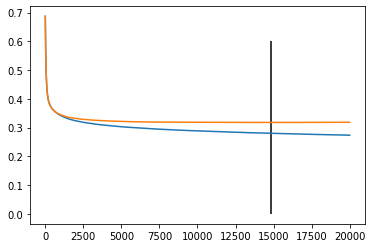

75


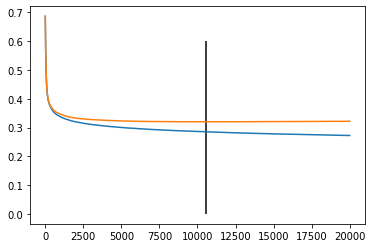

76


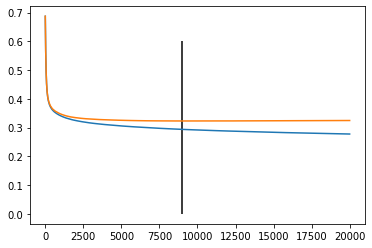

77


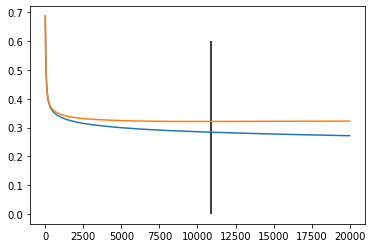

78


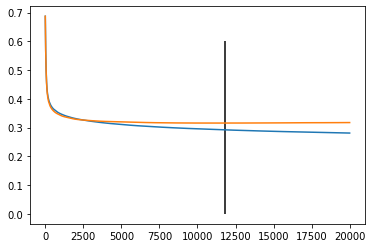

79


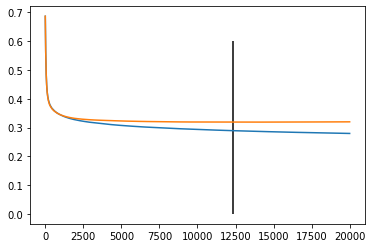

80


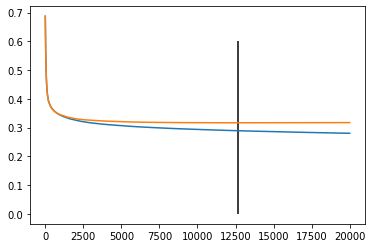

81


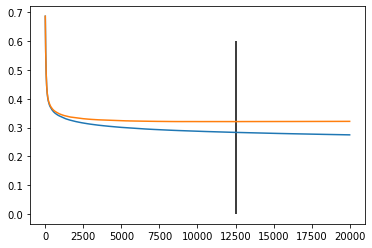

82


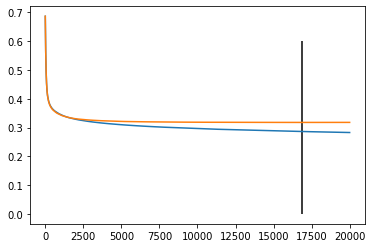

83


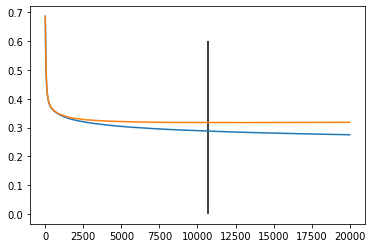

84


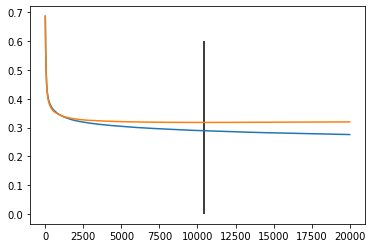

85


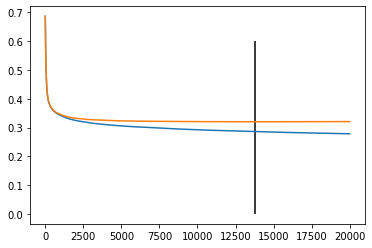

86


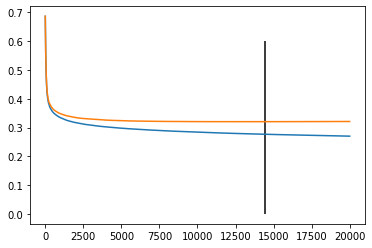

87


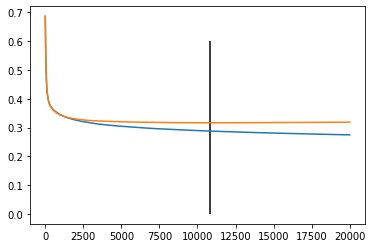

88


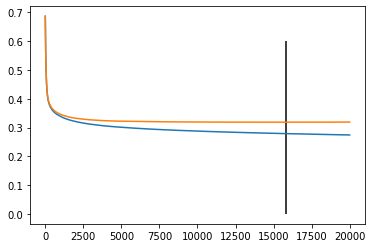

89


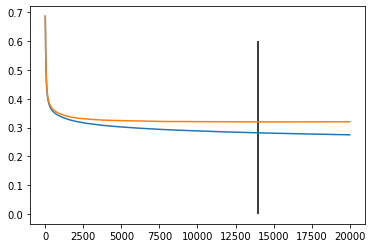

90


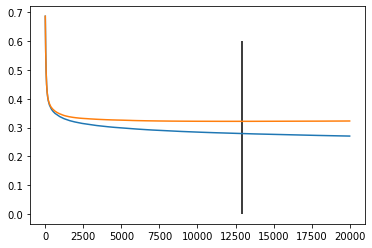

91


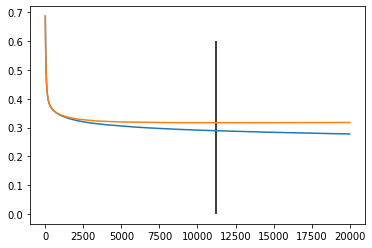

92


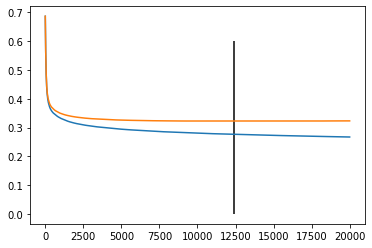

93


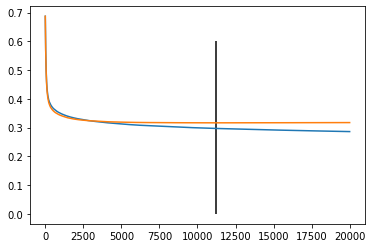

94


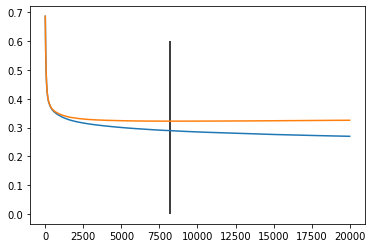

95


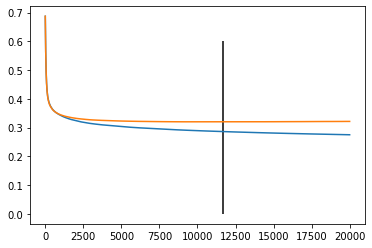

96


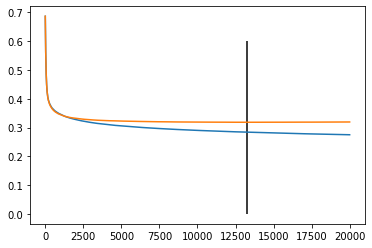

97


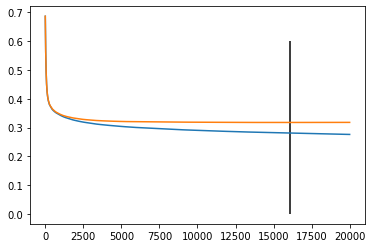

98


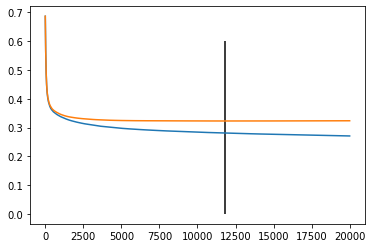

99


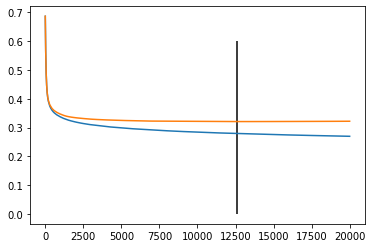

['/content/drive/MyDrive/Desafio_Kaggle/clf2_list3.pkl']

In [42]:
clf_list2 = []
best_iteration_list2 = []

for i in range(0,int(len(dict_Xy_modelo)/2)):

  clf = CatBoostClassifier(iterations = 20000, learning_rate = 0.01, depth = 1, 
                           eval_metric = 'Logloss', loss_function = 'Logloss')

  eval_set = [(dict_Xy_modelo['Treino_'+str(i+1)][0][cols_modelo_fil], dict_Xy_modelo['Treino_'+str(i+1)][1]), 
              (dict_Xy_modelo['Validacao_'+str(i+1)][0][cols_modelo_fil], dict_Xy_modelo['Validacao_'+str(i+1)][1])]
  clf.fit(dict_Xy_modelo['Treino_'+str(i+1)][0][cols_modelo_fil], dict_Xy_modelo['Treino_'+str(i+1)][1], eval_set = eval_set, 
          early_stopping_rounds = None, verbose = False)

  clf_list2.append(clf)
  best_iteration_list2.append(clf.get_best_iteration())

  print(i)
  plt.plot(clf.evals_result_['validation_0']['Logloss'])
  plt.plot(clf.evals_result_['validation_1']['Logloss'])
  plt.vlines(clf.get_best_iteration(), 0, 0.6)
  plt.show()

joblib.dump(best_iteration_list2, path_notebook + 'best_iteration2_list3.pkl')
joblib.dump(clf_list2, path_notebook + 'clf2_list3.pkl')

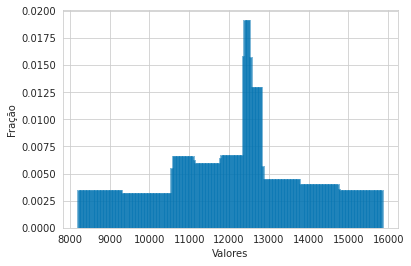

12342


In [97]:
best_iteration_list2 = joblib.load(path_notebook + 'best_iteration2_list3.pkl')
clf_list2 = joblib.load(path_notebook + 'clf2_list3.pkl')

dist_iterations = trf.CortaIntervalosQuasiUniforme(np.array(best_iteration_list2), num_div = 10)
dist_iterations.grafico_distribuicao(bins = 200)

vetor_iters, vetor_fracs, _ = dist_iterations.curva_distribuicao(bins = 200)
vetor_fracs_acum = np.cumsum(vetor_fracs)

ind_inter_moda = np.sum(vetor_fracs_acum < 0.5)
if(vetor_fracs_acum[ind_inter_moda] == 0.5):
  max_iter = round(vetor_iters[ind_inter_moda])
else:
  max_iter = round((vetor_iters[ind_inter_moda] + vetor_iters[ind_inter_moda-1])/2)

#max_iter = min(best_iteration_list2)

print(max_iter)

In [36]:
list_df_imp2 = []

for i in range(0,int(len(dict_Xy_modelo)/2)):

  clf = clf_list2[i]

  df_val = dict_Xy_modelo['Validacao_'+str(i+1)][0][cols_modelo_fil].copy()
  df_val[alvo] = dict_Xy_modelo['Validacao_'+str(i+1)][1]

  explic_imp = exp.ImportanciaVariaveisClassificacao(clf, df_val, alvo, cols_features = cols_modelo_fil, num_loop = 5, random_state = 42)
  df_logloss = pd.DataFrame(pd.Series(explic_imp.retorna_piora_logloss()), columns = ['Piora_Logloss'])

  print(i)
  #display(df_logloss)
  list_df_imp2.append(df_logloss)

0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: ignored

In [ ]:
df_imp2_concat = pd.concat(list_df_imp2, axis = 1)
qtd_neg = (df_imp2_concat < 0).sum(axis = 1)
qtd_pos = (df_imp2_concat > 0).sum(axis = 1)
qtd_zero = (df_imp2_concat == 0).sum(axis = 1)
media = df_imp2_concat.mean(axis = 1)
desvio = df_imp2_concat.std(axis = 1)
df_imp2_concat['QTD_Neg'] = qtd_neg
df_imp2_concat['QTD_Pos'] = qtd_pos
df_imp2_concat['QTD_Zero'] = qtd_zero
df_imp2_concat['Media'] = media
df_imp2_concat['Desvio'] = desvio
df_imp2_concat = df_imp2_concat[['Media', 'Desvio', 'QTD_Pos', 'QTD_Zero', 'QTD_Neg']]
df_imp2_concat = df_imp2_concat.sort_values('QTD_Pos', ascending = True)
display(df_imp2_concat[(df_imp2_concat['QTD_Pos'] <= 50) | (df_imp2_concat['Media'] <= 0)].sort_values('Media', ascending = False))

# Catboost - Treino com todos os dados

In [98]:
clf_tot = CatBoostClassifier(iterations = max_iter, learning_rate = 0.01, depth = 1, 
                             eval_metric = 'Logloss', loss_function = 'Logloss')

clf_tot.fit(df_intermed[cols_modelo_fil], df_intermed[alvo], 
            early_stopping_rounds = None, verbose = False)

In [99]:
class EnsembleClassifier():

  def __init__(self, clf_list):
    self.clf_list = clf_list

  def predict_proba(self, X):
    return reduce(lambda x, y: x+y, [clf.predict_proba(X) for clf in self.clf_list]) / len(self.clf_list)

In [100]:
#clf_ens = EnsembleClassifier(clf_list)
clf_ens = EnsembleClassifier([clf_tot])

# Avaliação

In [101]:
probs_intermed = clf_ens.predict_proba(df_intermed.drop(colunas_id, axis = 1).drop(alvo, axis = 1))[:, 1]
df_intermed_aval = df_intermed.copy()
df_intermed_aval['Prob'] = probs_intermed

if(frac_teste == 0):
  dict_dfs = {'Treino': df_intermed_aval}
else:
  probs_teste = clf_ens.predict_proba(df_teste.drop(colunas_id, axis = 1).drop(alvo, axis = 1))[:, 1]
  df_teste_aval = df_teste.copy()
  df_teste_aval['Prob'] = probs_teste

  dict_dfs = {'Treino': df_intermed_aval,
              'Teste': df_teste_aval}

In [102]:
avaliacaoclf = aml.AvaliaDatasetsClassificacao(dict_dfs, 
                                               alvo, 
                                               'Prob', 
                                               num_div_prob = 200, 
                                               num_div = 10, 
                                               num_cat = 5, 
                                               unit = None, 
                                               chave_treino = 'Treino')

,Treino
LogLoss,0.298490
CoefLogLoss,0.406446
CoefLogLoss_ref,0.406446
AUC,0.901896
KS,0.645807
IG,0.313369
IG_2D,0.366166
Frac_Incerto_2D,0.208171
Prob_Corte,0.265606
Prob0_Corte,0.135788


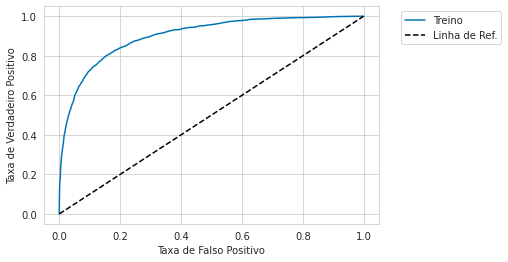

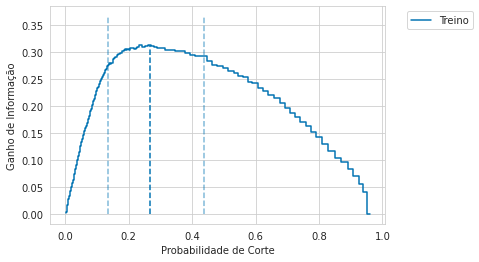

In [103]:
df_metricas = avaliacaoclf.valor_metricas().loc[['LogLoss', 'CoefLogLoss', 'CoefLogLoss_ref',
                                  'AUC', 'KS', 'IG', 'IG_2D', 'Frac_Incerto_2D', 
                                  'Prob_Corte', 'Prob0_Corte', 'Prob1_Corte',
                                  'Acurácia_Balanceada', 'Acurácia_Balanceada_2D',
                                  'P(0|0)', 'P_2D(0|0)', 'Frac_0',
                                  'P(1|1)', 'P_2D(1|1)', 'Frac_1'], :]

display(df_metricas)

avaliacaoclf.grafico_roc()
avaliacaoclf.grafico_informacao(mostrar_ig_2d = True)

In [104]:
from sklearn.metrics import f1_score

def get_best_probcut(y_real, y_prob):

  interv = trf.CortaIntervalosQuasiUniforme(y_prob, num_div = 200)
  y_prob = interv.aplica_discretizacao(y_prob)

  ind_order = np.argsort(y_prob)
  y_prob_ord = y_prob[ind_order]
  y_real_ord = y_real[ind_order]

  probs_unicos = np.unique(y_prob)
  f1_list = []
  for p in probs_unicos:
    y_pred = (y_prob > p).astype(int)
    f1 = f1_score(y_real, y_pred)
    f1_list.append(f1)

  ind_max = np.argmax(np.array(f1_list))
  prob_max = probs_unicos[ind_max]

  prob_max = (interv.info_discretizacao().loc[int(prob_max), 'Max'] + interv.info_discretizacao().loc[int(prob_max), 'Min'])/2
  return prob_max

In [105]:
p_corte = df_metricas.loc['Prob_Corte', 'Treino']
print(p_corte)

print('Treino:')
display(f1_score(df_intermed_aval[alvo].values, (df_intermed_aval['Prob'].values > p_corte).astype(int)))

if(frac_teste != 0):
  print('Teste:')
  display(f1_score(df_teste_aval[alvo].values, (df_teste_aval['Prob'].values > p_corte).astype(int)))

0.2656059152869954
Treino:


0.6859421734795613

In [106]:
p_corte_f1 = get_best_probcut(df_intermed_aval[alvo].values , df_intermed_aval['Prob'].values)
print(p_corte_f1)

print('Treino:')
display(f1_score(df_intermed_aval[alvo].values, (df_intermed_aval['Prob'].values > p_corte_f1).astype(int)))

if(frac_teste != 0):
  print('Teste:')
  display(f1_score(df_teste_aval[alvo].values, (df_teste_aval['Prob'].values > p_corte_f1).astype(int)))

0.2656059152869954
Treino:


0.6859421734795613

In [107]:
joblib.dump(clf_ens, path_notebook + 'clf_ens_ale_4.pkl')
joblib.dump([p_corte, p_corte_f1], path_notebook + 'probs_corte_ale_4.pkl')

['/content/drive/MyDrive/Desafio_Kaggle/probs_corte_ale_4.pkl']

In [108]:
clf_ens = joblib.load(path_notebook + 'clf_ens_ale_4.pkl')
p_corte, p_corte_f1 = joblib.load(path_notebook + 'probs_corte_ale_4.pkl')

# Aumentação de Dados

In [109]:
p0_corte = df_metricas.loc['Prob0_Corte', 'Treino']
p1_corte = df_metricas.loc['Prob1_Corte', 'Treino']

In [110]:
df_test = pd.read_csv('test.csv.zip')
df_test[df_test == -999] = np.nan

for col in cols_tot:
  df_test['nulo_' + col] = np.where(df_test[col].isna(), 1, 0)
  #df_test[col] = df_test[col].fillna(dict_imputer[col])

probs_test = clf_ens.predict_proba(df_test.drop(colunas_id, axis = 1)[cols_modelo])[:, 1]

In [111]:
alpha = 0.65

df_test[alvo] = np.nan
df_test.loc[probs_test <= p0_corte - alpha*(p0_corte - 0), alvo] = 0
df_test.loc[probs_test > p1_corte + alpha*(1 - p1_corte), alvo] = 1

In [112]:
#QTD Aumentação
len(df_test) - df_test[alvo].isna().sum()

6964

In [113]:
df_ext = pd.concat((df_intermed, df_test.loc[~df_test[alvo].isna(), :]))

In [114]:
clf_ext = CatBoostClassifier(iterations = max_iter, learning_rate = 0.01, depth = 1, 
                             eval_metric = 'Logloss', loss_function = 'Logloss')

clf_ext.fit(df_ext[cols_modelo_fil], df_ext[alvo], 
            early_stopping_rounds = None, verbose = False)

In [115]:
clf_ens_ext = EnsembleClassifier([clf_ext])

In [116]:
probs_intermed = clf_ens_ext.predict_proba(df_intermed.drop(colunas_id, axis = 1).drop(alvo, axis = 1))[:, 1]
df_intermed_aval_ext = df_intermed.copy()
df_intermed_aval_ext['Prob'] = probs_intermed

if(frac_teste == 0):
  dict_dfs_ext = {'Treino': df_intermed_aval_ext}
else:
  probs_teste = clf_ens_ext.predict_proba(df_teste.drop(colunas_id, axis = 1).drop(alvo, axis = 1))[:, 1]
  df_teste_aval_ext = df_teste.copy()
  df_teste_aval_ext['Prob'] = probs_teste

  dict_dfs_ext = {'Treino': df_intermed_aval_ext,
              'Teste': df_teste_aval_ext}

In [117]:
avaliacaoclf_ext = aml.AvaliaDatasetsClassificacao(dict_dfs_ext, 
                                                  alvo, 
                                                  'Prob', 
                                                  num_div_prob = 200, 
                                                  num_div = 10, 
                                                  num_cat = 5, 
                                                  unit = None, 
                                                  chave_treino = 'Treino')

,Treino
LogLoss,0.296811
CoefLogLoss,0.409784
CoefLogLoss_ref,0.409784
AUC,0.901421
KS,0.644432
IG,0.314030
IG_2D,0.367047
Frac_Incerto_2D,0.262834
Prob_Corte,0.256949
Prob0_Corte,0.098692


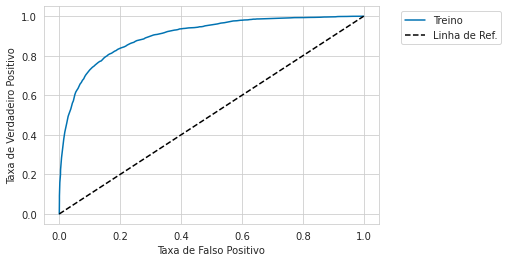

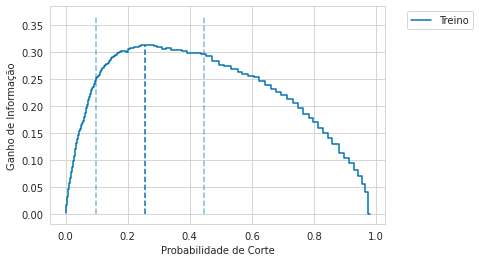

In [118]:
df_metricas_ext = avaliacaoclf_ext.valor_metricas().loc[['LogLoss', 'CoefLogLoss', 'CoefLogLoss_ref',
                                  'AUC', 'KS', 'IG', 'IG_2D', 'Frac_Incerto_2D', 
                                  'Prob_Corte', 'Prob0_Corte', 'Prob1_Corte',
                                  'Acurácia_Balanceada', 'Acurácia_Balanceada_2D',
                                  'P(0|0)', 'P_2D(0|0)', 'Frac_0',
                                  'P(1|1)', 'P_2D(1|1)', 'Frac_1'], :]

display(df_metricas_ext)

avaliacaoclf_ext.grafico_roc()
avaliacaoclf_ext.grafico_informacao(mostrar_ig_2d = True)

In [119]:
p_corte_ext = df_metricas_ext.loc['Prob_Corte', 'Treino']
print(p_corte_ext)

print('Treino:')
display(f1_score(df_intermed_aval[alvo].values, (df_intermed_aval_ext['Prob'].values > p_corte_ext).astype(int)))

if(frac_teste != 0):
  print('Teste:')
  display(f1_score(df_teste_aval[alvo].values, (df_teste_aval_ext['Prob'].values > p_corte_ext).astype(int)))

0.2569494482356446
Treino:


0.6862777321281841

In [120]:
p_corte_f1_ext = get_best_probcut(df_intermed_aval[alvo].values , df_intermed_aval['Prob'].values)
print(p_corte_f1_ext)

print('Treino:')
display(f1_score(df_intermed_aval[alvo].values, (df_intermed_aval_ext['Prob'].values > p_corte_f1_ext).astype(int)))

if(frac_teste != 0):
  print('Teste:')
  display(f1_score(df_teste_aval[alvo].values, (df_teste_aval_ext['Prob'].values > p_corte_f1_ext).astype(int)))

0.2656059152869954
Treino:


0.6853634251576501

In [121]:
joblib.dump(clf_ens_ext, path_notebook + 'clf_ens_ale_4_ext.pkl')
joblib.dump([p_corte_ext, p_corte_f1_ext], path_notebook + 'probs_corte_ale_4_ext.pkl')

['/content/drive/MyDrive/Desafio_Kaggle/probs_corte_ale_4_ext.pkl']

In [122]:
clf_ens_ext = joblib.load(path_notebook + 'clf_ens_ale_4_ext.pkl')
p_corte_ext, p_corte_f1_ext = joblib.load(path_notebook + 'probs_corte_ale_4_ext.pkl')

# Explicabilidade

In [79]:
explic_imp = exp.ImportanciaVariaveisClassificacao(clf_ens_ext, df_ext, alvo, cols_features = cols_modelo, num_loop = 5, random_state = 42)

In [80]:
df_logloss = pd.DataFrame(pd.Series(explic_imp.retorna_piora_logloss()), columns = ['Piora_Logloss'])
df_logloss['Incerteza'] = explic_imp.retorna_incertezas_piora()
df_logloss = df_logloss.sort_values('Piora_Logloss', ascending = False)

<BarContainer object of 15 artists>

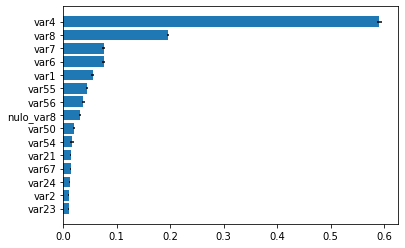

In [81]:
n_plot = 15
plt.barh(df_logloss.index[:n_plot][::-1], df_logloss[:n_plot]['Piora_Logloss'][::-1], xerr = df_logloss[:n_plot]['Incerteza'][::-1])

In [ ]:
for col in df_logloss.index[:n_plot]:
  avaliacaoclf_ext.calcula_metricas_condicionais(dict_dfs_ext, col)

In [ ]:
for col in df_logloss.index[:n_plot]:
  avaliacaoclf_ext.grafico_probabilidade_condicional(col, rot = 90)
  avaliacaoclf_ext.grafico_metricas_condicionais(col, metricas = ['KS'], rot = 90)

# Submissão

In [90]:
df_test = pd.read_csv('test.csv.zip')
len(df_test)

21183

In [91]:
df_test[df_test == -999] = np.nan

#### Diferença dos Datasets

In [ ]:
compara_datasets = dat.AvaliaDatasetsDistribuicoes({'Desenvolvimento': df[[c for c in cols_modelo if c[:4] != 'nulo']], 
                                                    'Kaggle': df_test[[c for c in cols_modelo if c[:4] != 'nulo']]}, num_div = 10, num_cat = 5, autorun = True)
compara_datasets.grafico_distribuicao(bins = 20)

In [ ]:
compara_datasets = dat.AvaliaDatasetsDistribuicoes({'Desenvolvimento': df.drop(cols_modelo, axis = 1).drop(alvo, axis = 1), 
                                                    'Kaggle': df_test.drop([c for c in cols_modelo if c[:4] != 'nulo'], axis = 1)}, num_div = 10, num_cat = 5, autorun = True)
compara_datasets.grafico_distribuicao(bins = 20)

#### predição

In [92]:
for col in cols_tot:
  df_test['nulo_' + col] = np.where(df_test[col].isna(), 1, 0)
  #df_test[col] = df_test[col].fillna(dict_imputer[col])

In [123]:
probs_test = clf_ens_ext.predict_proba(df_test.drop(colunas_id, axis = 1)[cols_modelo_fil])[:, 1]
#probs_test = clf_ens.predict_proba(df_test.drop(colunas_id, axis = 1)[cols_modelo_fil])[:, 1]

In [124]:
pred_test = (probs_test > p_corte_ext).astype(int)
#pred_test = (probs_test > p_corte_f1_ext).astype(int)

#pred_test = (probs_test > p_corte).astype(int)
#pred_test = (probs_test > p_corte_f1).astype(int)

In [125]:
df_sub = df_test[['id']].copy()
df_sub['predicted'] = pred_test
df_sub.to_csv(path_notebook + 'submission_featureselection_ale_4_ext.csv',index = False)
df_sub.to_csv('submission_featureselection_ale_4_ext.csv',index = False)
display(df_sub)

,id,predicted
0,0,1
1,2,1
2,4,0
3,7,1
4,15,1
...,...,...
21178,35297,0
21179,35298,0
21180,35300,1
21181,35302,0


In [126]:
!kaggle competitions submit -c porto-seguro-data-challenge -f submission_featureselection_ale_4_ext.csv -m 'nosso baseline'

100% 159k/159k [00:00<00:00, 446kB/s]
Successfully submitted to Porto Seguro Data Challenge